## Challenge: A deep dive into Dialogue Act Recognition - PART 2/2
**By**: *Ward Van den Bossche*, **Student ID**: *0605083*

In [17]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Assuming your notebook is in a subfolder, and you want to go up 1 or more levels to project root
project_root = os.path.dirname(os.getcwd())

# Optional: add root to Python path for module imports
if project_root not in sys.path:
    sys.path.append(project_root)

import torch
import json
import torch.utils.data
from tqdm import tqdm
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from precompute_embeddings import run_embedding_extraction
from collections import Counter
import re
import csv
import time
from models import ContextNet
from utils import compute_avg_training_time
from visualisations import plot_curve, generate_and_plot_confusion_matrix, \
plot_top_symmetric_misclassifications, plot_tsne, plot_tsne_zoomed
from train_structures import run_training_loop, evaluate

# Set random seed for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
parent_dir = os.path.dirname(os.getcwd())
path_to_dataset = os.path.join(parent_dir, 'SGD Dataset') # Assuming we're in a subfolder of the root
path_to_train = os.path.join(path_to_dataset, "TrainSet.json")
path_to_test = os.path.join(path_to_dataset, "TestSet.json")

### Implementation 2: Paper - "A Context-based Approach for Dialogue Act Recognition using Simple Recurrent Neural Networks"

The first implementation used embeddings of words, sequentially fed into an RNN, to build context-aware representations, based on a single utterance. 

This implementation is inspired by the approach proposed in Bothe et al. (2018), *A Context-Based Approach for Dialogue Act Recognition Using Simple Recurrent Neural Networks*, presented at the Eleventh International Conference on Language Resources and Evaluation (LREC 2018).

It has two major upgrades compared to the first implementation:
- First: it makes use of utterance-level embeddings, acquired from a model <ins>pretrained on a large corpus</ins> (~ 80 million amazon product reviews).
- Second: the final model stacks these utterance-level embeddings across dialogue turns to model dialogue context.

As a result, the model benefits from semantically richer representations while also having the context of multiple turns in the dialogue.

#### Preprocessing

The preprocessing is the same as implementation 1, we just want to get the act_labels and their corresponding number labels. The rest of the preprocessing is done in the dataset class itself.

In [6]:
EOD = "<eod>" # Define End of dialogue token as a global variable

In [7]:
def extract_turn_data(file_path):
    all_data = []
    with open(file_path, 'r') as f:
        data = json.load(f)
        for dialogue in data:
            for turn in dialogue['turns']:
                all_data.append({
                    'speaker': turn['speaker'],
                    'utterance': turn['utterance'],
                    'act': turn["dialogue_act"]
                })
            all_data[-1]['utterance'] += f" {EOD}" # Add an End Of Dialogue marker at the end of last utterance in turn
    return all_data

extracted_train = extract_turn_data(path_to_train)
extracted_test = extract_turn_data(path_to_test)

In [8]:
# A set makes it easy to find unique elements (removes duplicates)
acts = list(set([data['act'] for data in extracted_train] + [data['act'] for data in extracted_test]))

acts_labels = {act : i for i, act in enumerate(acts)}
inv_acts_labels = {v: k for k, v in acts_labels.items()}

We're only interested in the raw utterances of the test data, since it's just for visualisation purposes.

#### Code for precomputing an embedding vector for each utterance

This code will create a train_embeddings_\[average|last\].pt test_embeddings_\[average|last\].pt depending on
whether you want the mLSTM with pretrained weights to use the embedding from the last hidden state h_t or from
the average of all hidden states. These embeddings can then more easily be acquired during the training of our model.

The paper: **A context-based Approach for DA Recognition using Simple RNN** reads: 
"*This model consists of a single multiplicative long-short-term memory
(mLSTM) network (Krause et al., 2016) layer with 4,096 hidden units. The mLSTM 
is composed of an LSTM and a multiplicative RNN and considers each possible input in
a recurrent transition function. It is trained as a character language model on 
∼80 million Amazon product reviews
(Radford et al., 2017).*"

The original pretrained mLSTM can be found [here](https://github.com/openai/generating-reviews-discovering-sentiment) and can be
used as is, as a feature extractor. However, since that codebase uses TensorFlow, the one used in this notebook is the one cited as a [pytorch fork](https://github.com/guillitte/pytorch-sentiment-neuron) on that repository.

Running the following code cell will result in the creation of **test_embeddings_average.pt** and **train_embeddings_average.pt** files that contain a list of dialogues, where each dialogue contains an embedding of every utterance that occurs in the dialogue. For the actual implementation, the reader is referred to the code in **precompute_embeddings.py**.

In [9]:
run_embedding_extraction(model_path='mlstm_ns.pt', path_to_train=path_to_train, path_to_test=path_to_test)

Embeddings already exist. Skipping extraction.


#### Dataset

In the dataset some extra preprocessing is done, we want to collect the previous n utterances as context, so we make every sample a list of n utterances, with their corresponding labels. Instead of using raw utterances however, we use the embedding version acquired from the pretrained mLSTM, these were precomputed in the previous step.

In [10]:
class DialogueWindowDataset(Dataset):
    def __init__(self, embeddings_path, file_path, window_size=2):
        """
        Args:
            embeddings_path (str): Path to the precomputed embeddings file.
            file_path (str): Path to the JSON file containing dialogue data.
            window_size (int): Size of the context window. (e.g. 2 is 2 previous turns + current turn)
        """
        self.embeddings = torch.load(embeddings_path)
        self.window_size = window_size

        with open(file_path, 'r') as f:
            file_contents = json.load(f)
            dialogues = [dialogue['turns'] for dialogue in file_contents]
            self.data = []
            for dialog_idx, dialog in enumerate(tqdm(dialogues)):
                embeddings = self.embeddings[dialog_idx]
                speakers = [0 if turn['speaker'] == 'USER' else 1 for turn in dialog]
                labels = [acts_labels[turn['dialogue_act']] for turn in dialog]

                n = len(embeddings)
                for t in range(n):
                    window_emb = []
                    window_speaker = []
                    for i in range(t - self.window_size, t + 1):
                        if i >= 0:
                            emb = embeddings[i]
                            spk = torch.nn.functional.one_hot(
                                torch.tensor(speakers[i]), num_classes=2
                            ).float()
                        else:
                            emb = torch.zeros(4096)
                            spk = torch.zeros(2)
                        window_emb.append(emb)
                        window_speaker.append(spk)

                    window_emb = torch.stack(window_emb)  # (window_size + 1, embed_dim)
                    window_speaker = torch.stack(window_speaker)  # (window_size + 1, 2)
                    combined = torch.cat([window_emb, window_speaker], dim=1)  # (window_size + 1, embed_dim + 2)
                    label = labels[t]

                    self.data.append((combined, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

The result is a dataset where each batch contains n embeddings per sample (except at the start of a dialogue where there is no "previous utterance" to speak of).

In [11]:
# Define the dataset and dataloader
# In accordance with the paper, the average embedding is used for the mLSTM model, as it contains more information
train_dataset = DialogueWindowDataset(embeddings_path='train_embeddings_average.pt', file_path=path_to_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = DialogueWindowDataset(embeddings_path='test_embeddings_average.pt', file_path=path_to_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Example batch
for batch in train_loader:
    combined, labels = batch
    print(combined.shape)  # (batch_size, 3, embed_dim + 2)
    print(labels.shape)    # (batch_size,)
    break

C:\Users\Ward\AppData\Local\Temp\ipykernel_10956\3759199132.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(embeddings_path)
100%|██████████

torch.Size([128, 3, 4098])
torch.Size([128])


#### Architecture

The final model's input size is based on the embedding size returned by our pretrained mLSTM model, which is 4096. The hidden size is kept the same as our previous model.

In [12]:
# Hyperparameters
input_size = 4096 + 2  # Embedding dimension + speaker one-hot
hidden_size = 32
num_classes = len(acts_labels)  # Number of dialogue acts
pooling_type = 'average'  # 'last_hidden_state' or 'average'

# Initialize model, optimizer, and criterion
model = ContextNet(input_size, hidden_size, num_classes, pooling_type).to(device)

#### Training

The training, evaluation and visualisation section remains similar to the first implementation, with small adaptations to account for the different input (speaker info is already added in the dataset creation).

In [13]:
def prepare_batch_v2(batch):
    combined, labels = batch
    return [combined], labels

def forward_v2(model, combined):
    return model(combined)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 50

In [ ]:
losses, accuracies = run_training_loop(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    prepare_batch=prepare_batch_v2,
    forward=forward_v2,
    save_dir="train_logs"
)

100%|██████████| 646/646 [00:05<00:00, 119.86it/s]


Epoch 1/50, Train Loss: 1.640, Train Accuracy: 57.985


100%|██████████| 646/646 [00:05<00:00, 126.50it/s]


Epoch 2/50, Train Loss: 0.589, Train Accuracy: 86.195


100%|██████████| 646/646 [00:05<00:00, 122.87it/s]


Epoch 3/50, Train Loss: 0.362, Train Accuracy: 92.334


100%|██████████| 646/646 [00:05<00:00, 126.33it/s]


Epoch 4/50, Train Loss: 0.248, Train Accuracy: 94.950


100%|██████████| 646/646 [00:05<00:00, 125.00it/s]


Epoch 5/50, Train Loss: 0.182, Train Accuracy: 96.296


100%|██████████| 646/646 [00:05<00:00, 118.53it/s]


Epoch 6/50, Train Loss: 0.141, Train Accuracy: 97.082


100%|██████████| 646/646 [00:05<00:00, 122.37it/s]


Epoch 7/50, Train Loss: 0.112, Train Accuracy: 97.627


100%|██████████| 646/646 [00:05<00:00, 123.75it/s]


Epoch 8/50, Train Loss: 0.092, Train Accuracy: 98.057


100%|██████████| 646/646 [00:05<00:00, 121.70it/s]


Epoch 9/50, Train Loss: 0.076, Train Accuracy: 98.380


100%|██████████| 646/646 [00:05<00:00, 115.44it/s]


Epoch 10/50, Train Loss: 0.065, Train Accuracy: 98.629


100%|██████████| 646/646 [00:05<00:00, 121.43it/s]


Epoch 11/50, Train Loss: 0.055, Train Accuracy: 98.859


100%|██████████| 646/646 [00:05<00:00, 115.18it/s]


Epoch 12/50, Train Loss: 0.047, Train Accuracy: 99.030


100%|██████████| 646/646 [00:05<00:00, 119.76it/s]


Epoch 13/50, Train Loss: 0.040, Train Accuracy: 99.192


100%|██████████| 646/646 [00:05<00:00, 120.36it/s]


Epoch 14/50, Train Loss: 0.035, Train Accuracy: 99.289


100%|██████████| 646/646 [00:05<00:00, 120.05it/s]


Epoch 15/50, Train Loss: 0.031, Train Accuracy: 99.416


100%|██████████| 646/646 [00:05<00:00, 123.49it/s]


Epoch 16/50, Train Loss: 0.027, Train Accuracy: 99.499


100%|██████████| 646/646 [00:05<00:00, 117.47it/s]


Epoch 17/50, Train Loss: 0.024, Train Accuracy: 99.583


100%|██████████| 646/646 [00:05<00:00, 120.68it/s]


Epoch 18/50, Train Loss: 0.021, Train Accuracy: 99.628


100%|██████████| 646/646 [00:05<00:00, 113.98it/s]


Epoch 19/50, Train Loss: 0.018, Train Accuracy: 99.679


100%|██████████| 646/646 [00:05<00:00, 119.60it/s]


Epoch 20/50, Train Loss: 0.016, Train Accuracy: 99.728


100%|██████████| 646/646 [00:05<00:00, 117.50it/s]


Epoch 21/50, Train Loss: 0.014, Train Accuracy: 99.765


100%|██████████| 646/646 [00:05<00:00, 116.06it/s]


Epoch 22/50, Train Loss: 0.013, Train Accuracy: 99.792


100%|██████████| 646/646 [00:05<00:00, 122.35it/s]


Epoch 23/50, Train Loss: 0.011, Train Accuracy: 99.841


100%|██████████| 646/646 [00:05<00:00, 112.67it/s]


Epoch 24/50, Train Loss: 0.010, Train Accuracy: 99.841


100%|██████████| 646/646 [00:05<00:00, 121.27it/s]


Epoch 25/50, Train Loss: 0.009, Train Accuracy: 99.864


100%|██████████| 646/646 [00:05<00:00, 127.50it/s]


Epoch 26/50, Train Loss: 0.007, Train Accuracy: 99.881


100%|██████████| 646/646 [00:05<00:00, 129.03it/s]


Epoch 27/50, Train Loss: 0.007, Train Accuracy: 99.916


100%|██████████| 646/646 [00:05<00:00, 128.62it/s]


Epoch 28/50, Train Loss: 0.006, Train Accuracy: 99.924


100%|██████████| 646/646 [00:05<00:00, 128.63it/s]


Epoch 29/50, Train Loss: 0.005, Train Accuracy: 99.935


100%|██████████| 646/646 [00:04<00:00, 129.50it/s]


Epoch 30/50, Train Loss: 0.005, Train Accuracy: 99.915


100%|██████████| 646/646 [00:05<00:00, 127.06it/s]


Epoch 31/50, Train Loss: 0.004, Train Accuracy: 99.949


100%|██████████| 646/646 [00:05<00:00, 128.08it/s]


Epoch 32/50, Train Loss: 0.004, Train Accuracy: 99.958


100%|██████████| 646/646 [00:05<00:00, 127.89it/s]


Epoch 33/50, Train Loss: 0.004, Train Accuracy: 99.958


100%|██████████| 646/646 [00:05<00:00, 125.89it/s]


Epoch 34/50, Train Loss: 0.003, Train Accuracy: 99.958


100%|██████████| 646/646 [00:05<00:00, 123.95it/s]


Epoch 35/50, Train Loss: 0.004, Train Accuracy: 99.952


100%|██████████| 646/646 [00:04<00:00, 130.66it/s]


Epoch 36/50, Train Loss: 0.004, Train Accuracy: 99.935


100%|██████████| 646/646 [00:04<00:00, 129.27it/s]


Epoch 37/50, Train Loss: 0.002, Train Accuracy: 99.988


100%|██████████| 646/646 [00:04<00:00, 129.29it/s]


Epoch 38/50, Train Loss: 0.002, Train Accuracy: 99.979


100%|██████████| 646/646 [00:05<00:00, 128.92it/s]


Epoch 39/50, Train Loss: 0.004, Train Accuracy: 99.925


100%|██████████| 646/646 [00:05<00:00, 128.67it/s]


Epoch 40/50, Train Loss: 0.004, Train Accuracy: 99.941


100%|██████████| 646/646 [00:04<00:00, 129.48it/s]


Epoch 41/50, Train Loss: 0.002, Train Accuracy: 99.989


100%|██████████| 646/646 [00:05<00:00, 129.11it/s]


Epoch 42/50, Train Loss: 0.001, Train Accuracy: 99.996


100%|██████████| 646/646 [00:05<00:00, 128.19it/s]


Epoch 43/50, Train Loss: 0.002, Train Accuracy: 99.975


100%|██████████| 646/646 [00:05<00:00, 127.87it/s]


Epoch 44/50, Train Loss: 0.003, Train Accuracy: 99.926


100%|██████████| 646/646 [00:05<00:00, 128.12it/s]


Epoch 45/50, Train Loss: 0.003, Train Accuracy: 99.953


100%|██████████| 646/646 [00:05<00:00, 122.35it/s]


Epoch 46/50, Train Loss: 0.001, Train Accuracy: 99.992


100%|██████████| 646/646 [00:05<00:00, 121.52it/s]


Epoch 47/50, Train Loss: 0.001, Train Accuracy: 99.994


100%|██████████| 646/646 [00:05<00:00, 128.57it/s]


Epoch 48/50, Train Loss: 0.003, Train Accuracy: 99.926


100%|██████████| 646/646 [00:05<00:00, 128.91it/s]


Epoch 49/50, Train Loss: 0.001, Train Accuracy: 99.994


100%|██████████| 646/646 [00:05<00:00, 128.65it/s]

Epoch 50/50, Train Loss: 0.001, Train Accuracy: 99.996

 Training complete. Model saved to 'train_logs\model.pth', stats saved to 'train_logs\train_stats.csv'


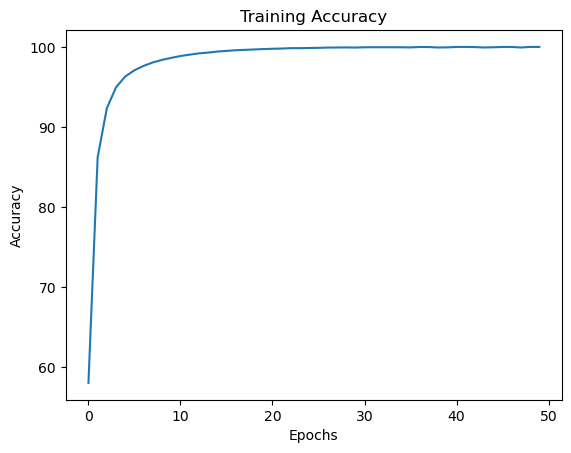

In [54]:
plot_curve(accuracies, "Epochs", "Accuracy", "Training Accuracy")

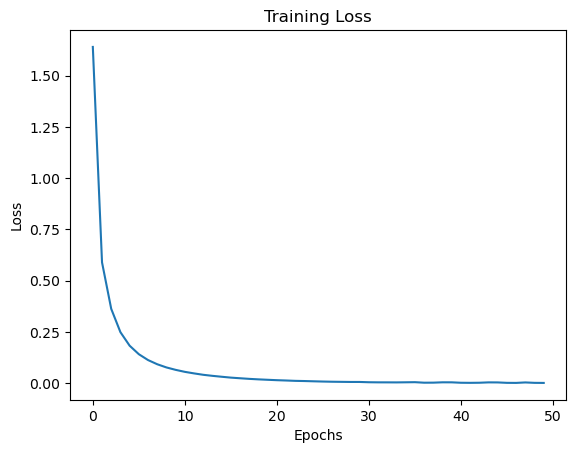

In [55]:
plot_curve(losses, "Epochs", "Loss", "Training Loss")

#### Evaluation

In [72]:
# Evaluate on the test set
metrics = evaluate(model, test_loader, prepare_batch_fn=prepare_batch_v2, forward_fn=forward_v2, inv_act_labels=inv_acts_labels)

100%|██████████| 132/132 [00:05<00:00, 23.21it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 Evaluation Results:
Top-1 Accuracy: 94.49%
Top-5 Accuracy: 99.49%
Balanced Accuracy: 85.61%

 Classification Report:
                                                   precision    recall  f1-score   support

                                   SYSTEM_CONFIRM       0.98      0.95      0.96      1113
                                   SYSTEM_GOODBYE       0.98      0.98      0.98      1331
                                    SYSTEM_INFORM       0.99      0.95      0.97       719
              SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS       0.99      0.96      0.98       310
 SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE       0.79      0.88      0.83        17
            SYSTEM_NOTIFY_FAILURE|SYSTEM_REQ_MORE       0.99      0.92      0.95        79
                            SYSTEM_NOTIFY_SUCCESS       0.97      0.99      0.98       499
                                     SYSTEM_OFFER       0.91      0.97      0.94       806
                              SYSTEM_OFFER_INTENT       0.92 

In [2]:
compute_avg_training_time('train_logs/train_stats.csv')

Average training time is: 5.2202076244354245 seconds


#### Visualisations

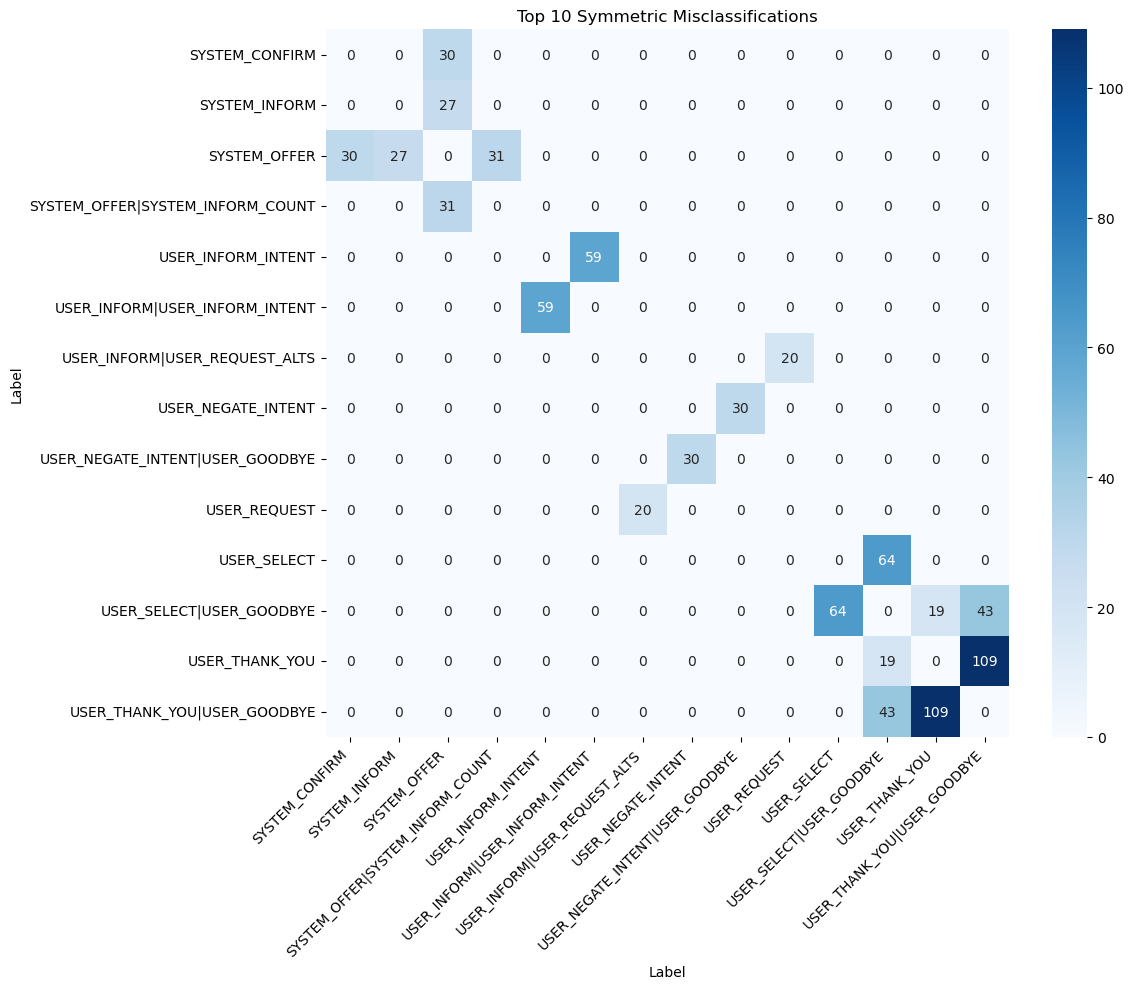

In [61]:
all_targets_named = metrics['y_true']
all_predictions_named = metrics['y_pred']

# Call the function to plot the top 10 misclassifications
plot_top_symmetric_misclassifications(all_targets_named, all_predictions_named, top_n=10)

Found 39 unique classes.
Generating confusion matrix plot...
Saved matrix plots to full_confusion_matrix.pdf and .png


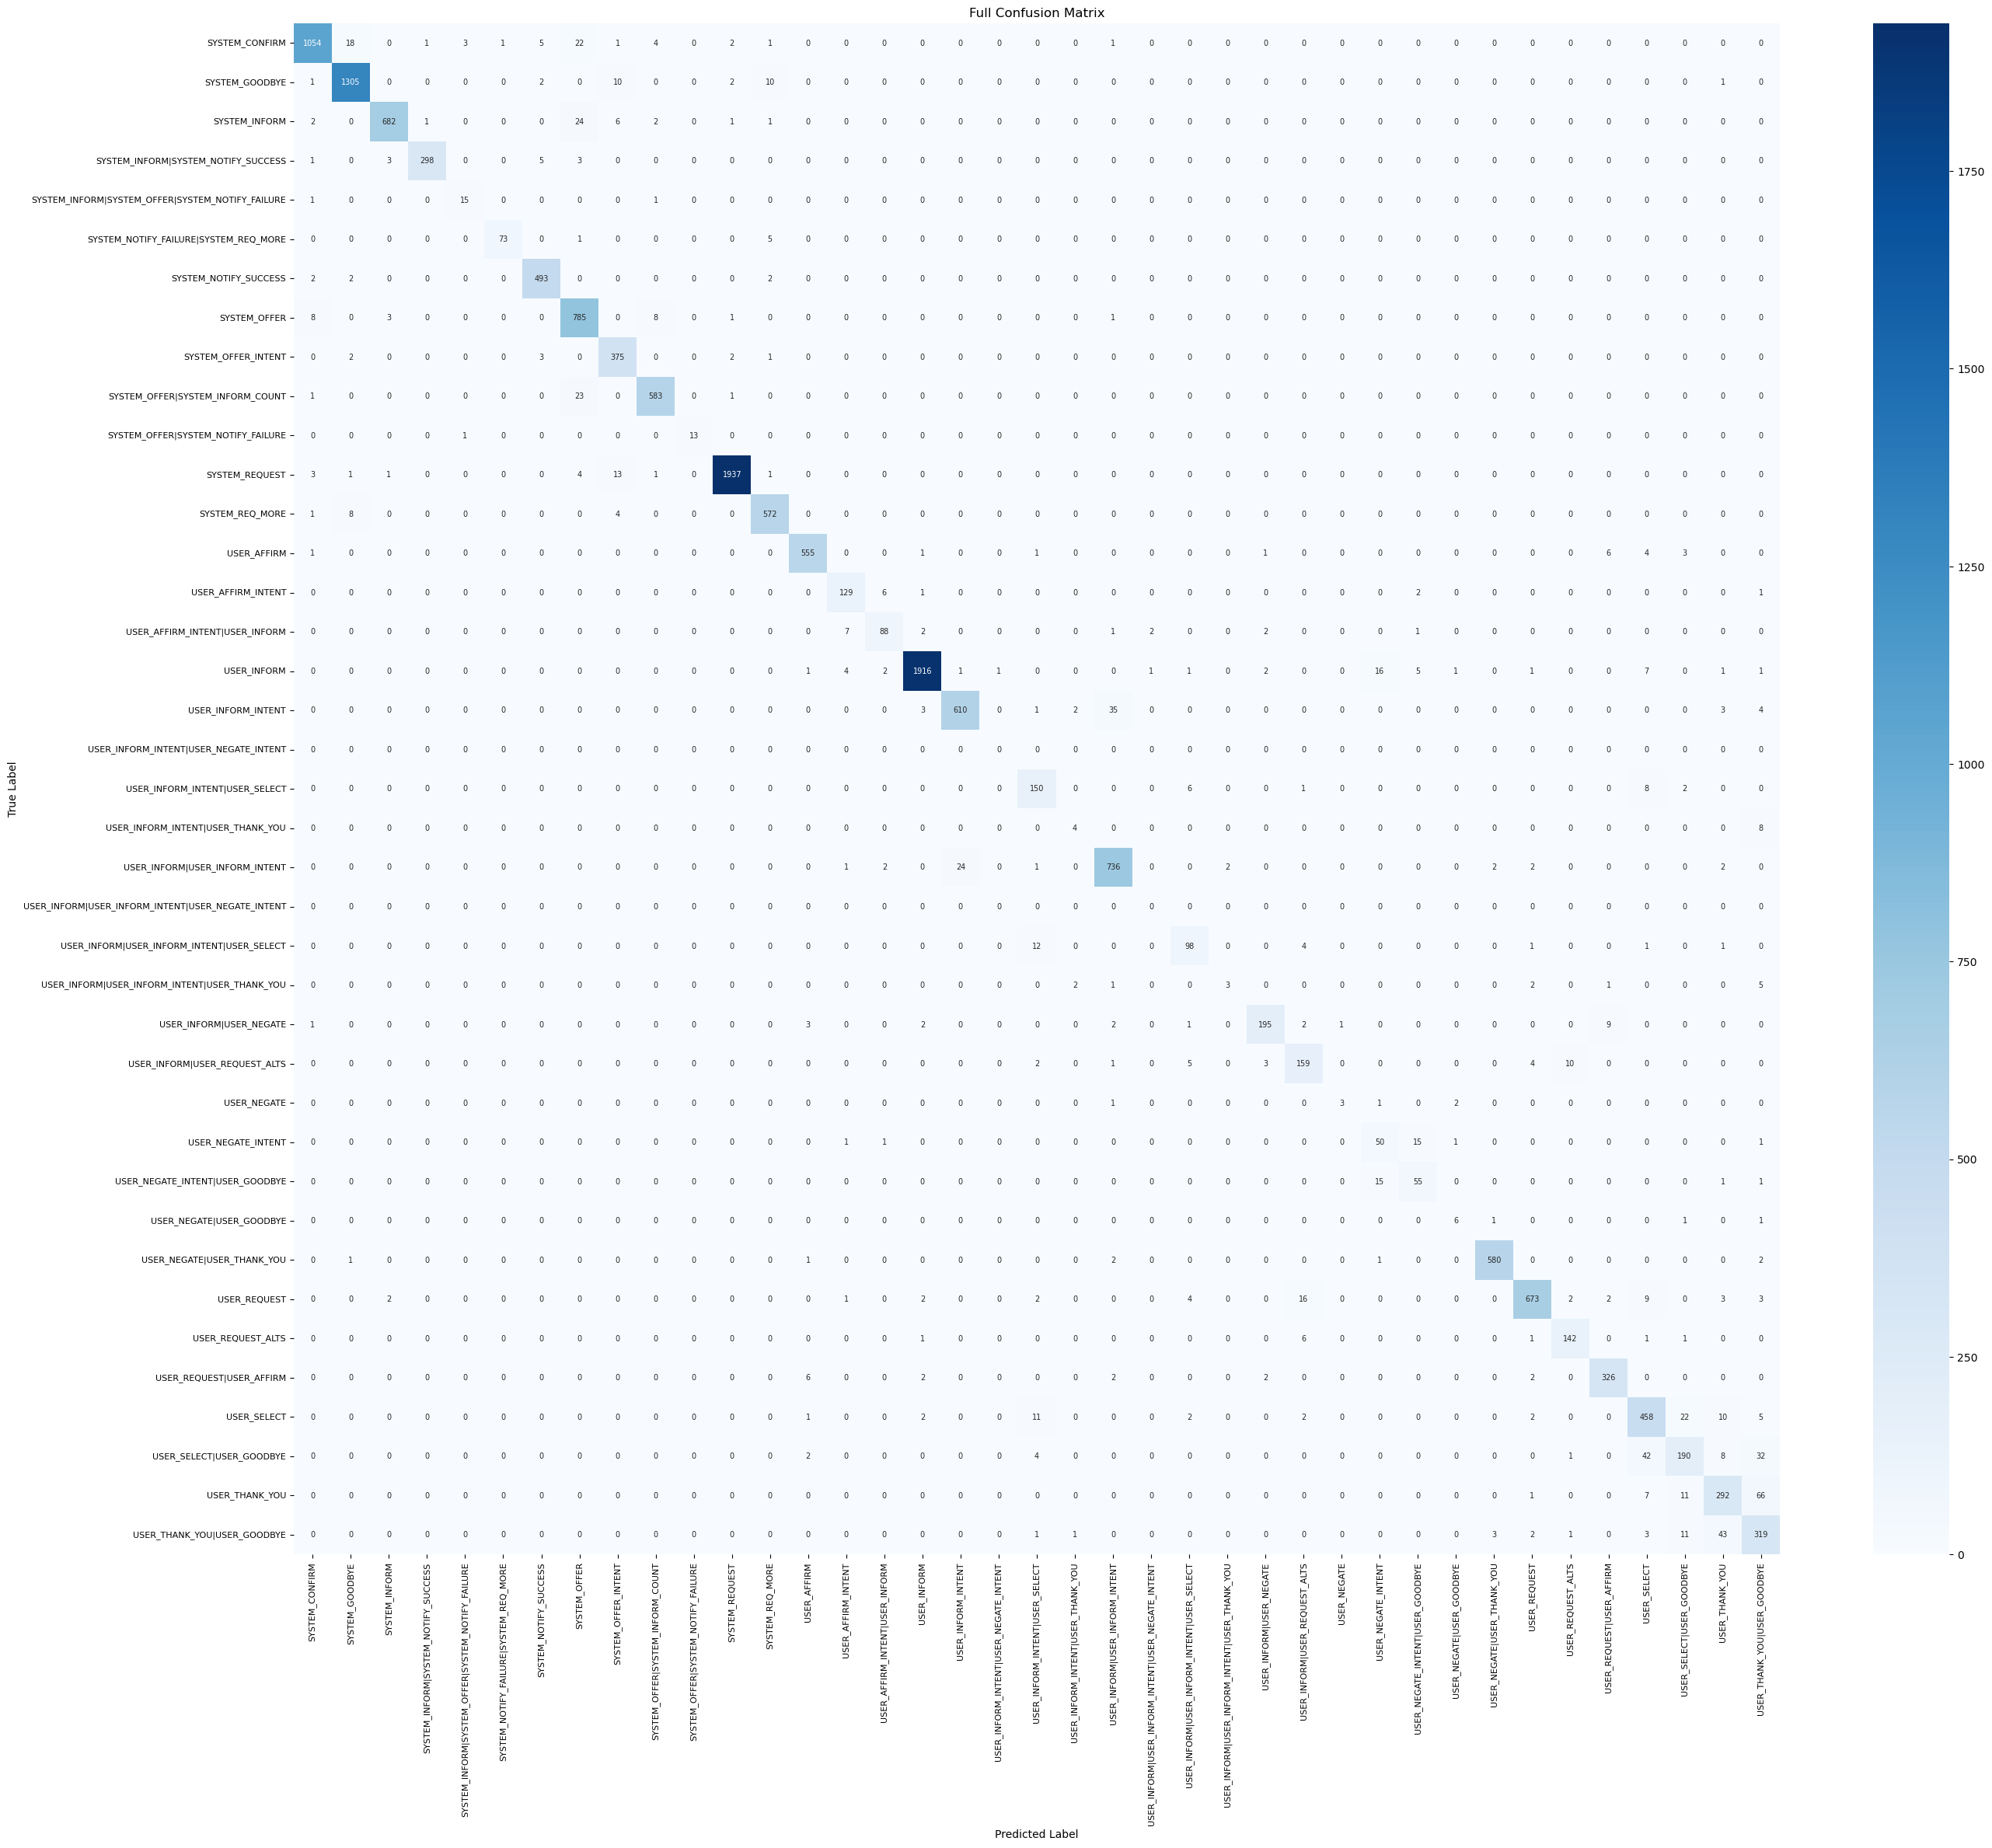

In [58]:
generate_and_plot_confusion_matrix(
    all_targets_named,
    all_predictions_named,
    figsize=(28, 24),        # Customize plot size
    annot_kws={"size": 7}    # Customize annotation font size
)

Saved plots to t-SNE of Top 10 Occuring Dialogue Acts.png


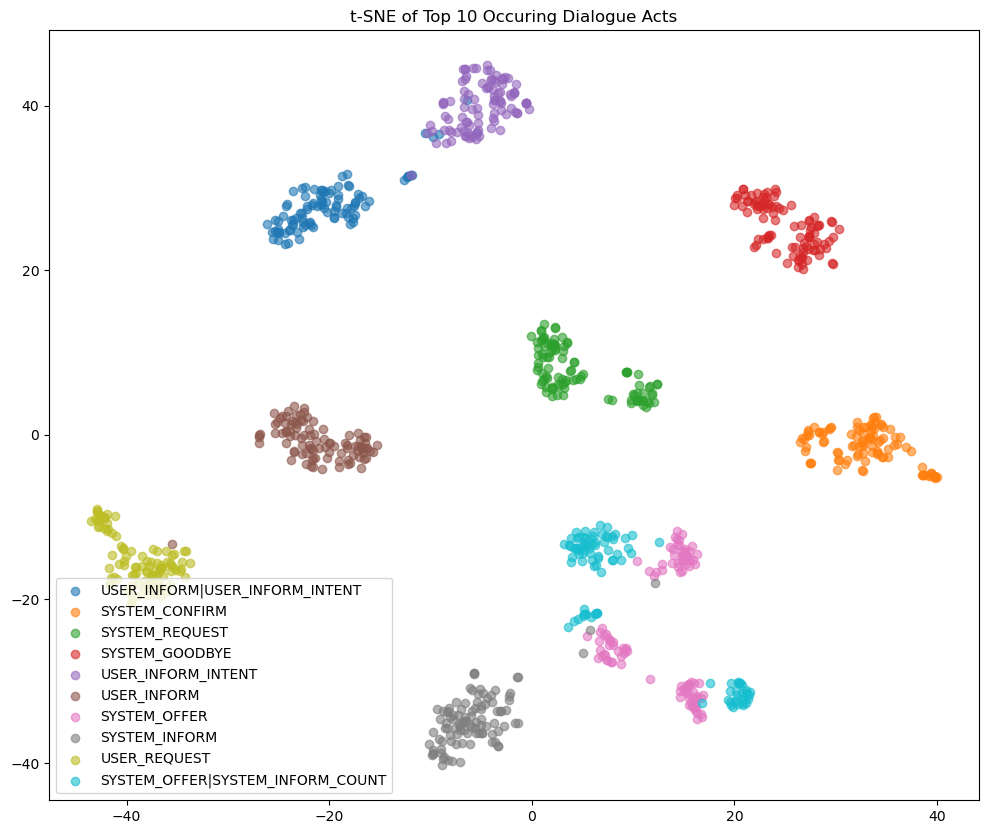

In [73]:
utterances = metrics["utterance_vectors"]
labels = metrics["y_true"]

# Filter the utterances and labels to only include the top labels
label_counts = Counter(metrics["y_true"])
top_labels = [label for label, _ in label_counts.most_common(10)]

plot_tsne(utterances, labels, top_labels, max_per_label=100, title="t-SNE of Top 10 Occuring Dialogue Acts")

In [75]:
utterances_test = [data['utterance'].lower() for data in extracted_test]

Saved plots to t-SNE of User Requests and System Informs, and User Inform Intents.png


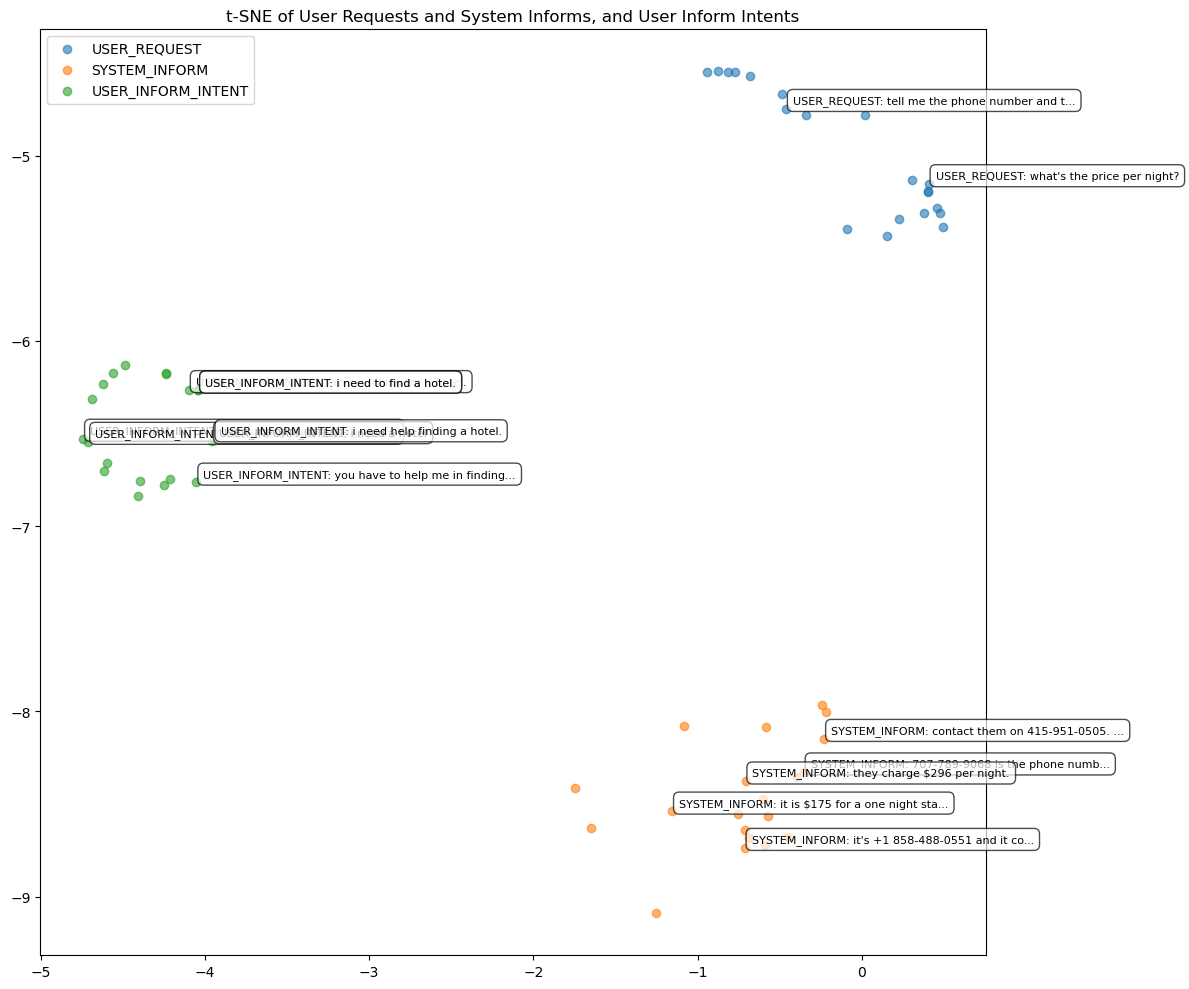

In [83]:
# Plot zoomed version for just a specific subset of acts
plot_tsne_zoomed(
    vectors=utterances,
    labels=labels,
    texts=utterances_test,
    selected_labels=['USER_REQUEST', 'SYSTEM_INFORM', 'USER_INFORM_INTENT'],  # Focus on these classes
    max_per_label=20,              # Limit points per class
    annotate_sample=0.3,           # Annotate 30% of points
    zoom_scale=1.0,                
    title="t-SNE of User Requests and System Informs, and User Inform Intents",
)

The model is so good at clustering that the clusters being this far apart makes it harder to differentiate, let's take a look at one specific dialogue act:

Saved plots to t-SNE of User Inform Intent.png


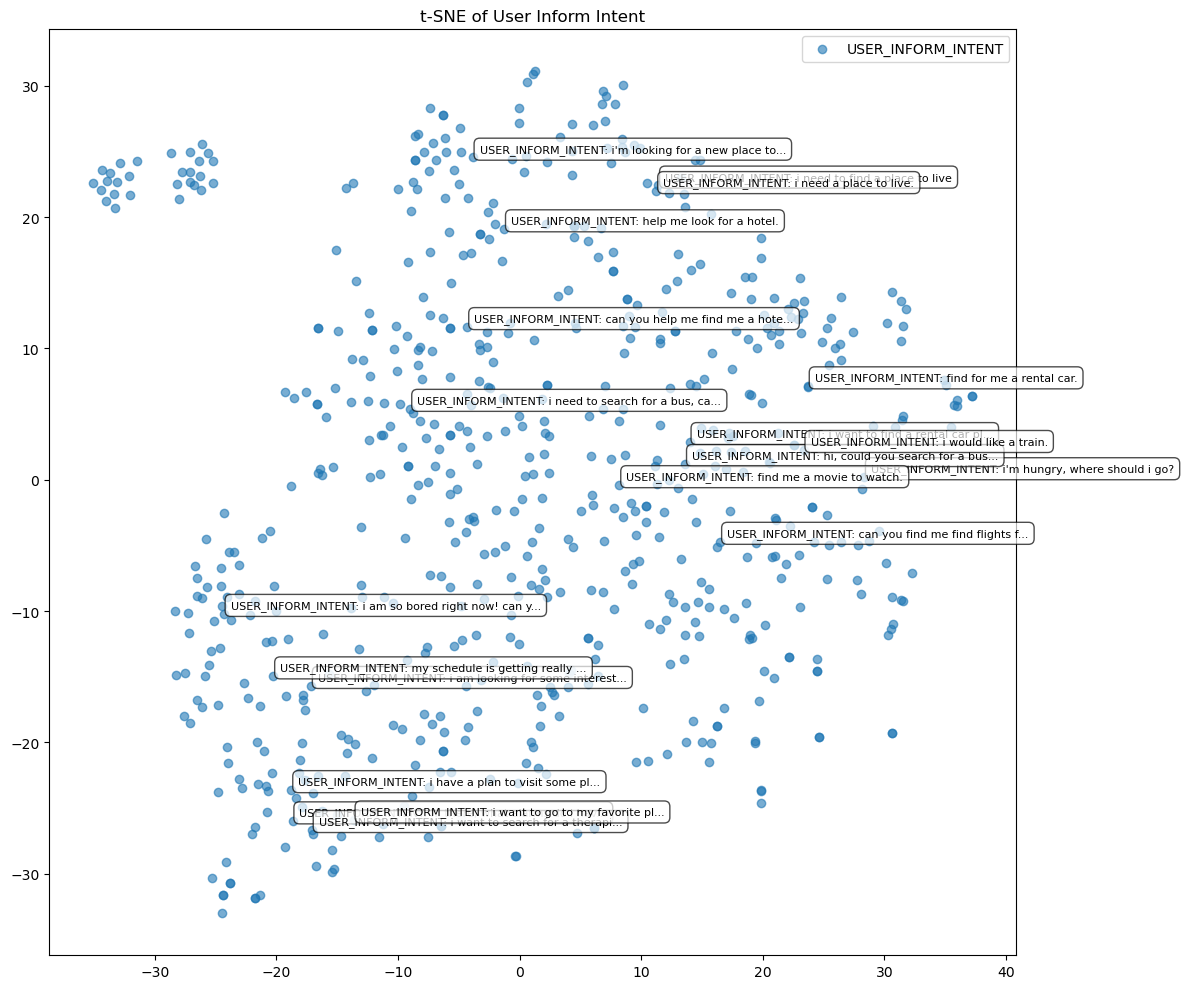

In [99]:
# Plot zoomed version for just a specific subset of acts
plot_tsne_zoomed(
    vectors=utterances,
    labels=labels,
    texts=utterances_test,
    selected_labels=['USER_INFORM_INTENT'],  # Focus on these classes
    max_per_label=1000,              # Limit points per class
    annotate_sample=0.03,           # Annotate 3% of points
    zoom_scale=1.0,                
    title="t-SNE of User Inform Intent",
)

#### Ablation study: context window size

We will now run an experiment to analyse the impact of window size in the dialogue recognition task. The window size decides how many previous utterances are used as context for the current one. Sizes [0, 10] will be checked, and the resulting accuracies and training times will be saved in a .csv file.

In [20]:
# Define where to save your results
results_file = "ablation_window_size_results.csv"

# Open CSV file for writing metrics
with open(results_file, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow([
        "window_size", "accuracy", "top5_accuracy", "balanced_accuracy", "dataset_creation_time_sec", "train_time_sec"
    ])

    for window_size in range(0, 11):  # From 0 to 10 inclusive
        print(f"\n=== Running training for window size: {window_size} ===")

        # Measure training time
        start_time_dataset = time.time()

        # Load datasets
        train_dataset = DialogueWindowDataset(
            embeddings_path='train_embeddings_average.pt',
            file_path=path_to_train,
            window_size=window_size
        )
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

        test_dataset = DialogueWindowDataset(
            embeddings_path='test_embeddings_average.pt',
            file_path=path_to_test,
            window_size=window_size
        )
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

        end_time_dataset = time.time()
        dataset_creation_time = end_time_dataset - start_time_dataset

        # Initialize model, optimizer, criterion
        model = ContextNet(input_size, hidden_size, num_classes, pooling_type).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = torch.nn.CrossEntropyLoss()

        train_start_time = time.time()

        # Train the model
        losses, accuracies = run_training_loop(
            model=model,
            train_loader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            num_epochs=num_epochs,
            prepare_batch=prepare_batch_v2,
            forward=forward_v2,
            save_dir=f"train_logs/window_{window_size}"
        )

        train_end_time = time.time()
        train_time = train_end_time - train_start_time

        # Evaluate on the test set
        metrics = evaluate(
            model=model,
            test_loader=test_loader,
            prepare_batch_fn=prepare_batch_v2,
            forward_fn=forward_v2,
            inv_act_labels=inv_acts_labels
        )

        # Write metrics to CSV
        writer.writerow([
            window_size,
            metrics["accuracy"],
            metrics["top5_accuracy"],
            metrics["balanced_accuracy"],
            round(dataset_creation_time, 2),
            round(train_time, 2)
        ])

print(f"\nAblation study completed! Results saved to '{results_file}'")


=== Running training for window size: 0 ===


C:\Users\Ward\AppData\Local\Temp\ipykernel_10956\3759199132.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(embeddings_path)
100%|██████████

Epoch 1/50, Train Loss: 1.130, Train Accuracy: 74.588


100%|██████████| 646/646 [00:02<00:00, 281.60it/s]


Epoch 2/50, Train Loss: 0.401, Train Accuracy: 89.584


100%|██████████| 646/646 [00:02<00:00, 262.92it/s]


Epoch 3/50, Train Loss: 0.293, Train Accuracy: 91.936


100%|██████████| 646/646 [00:02<00:00, 274.78it/s]


Epoch 4/50, Train Loss: 0.245, Train Accuracy: 92.974


100%|██████████| 646/646 [00:02<00:00, 276.54it/s]


Epoch 5/50, Train Loss: 0.217, Train Accuracy: 93.730


100%|██████████| 646/646 [00:02<00:00, 277.85it/s]


Epoch 6/50, Train Loss: 0.197, Train Accuracy: 94.238


100%|██████████| 646/646 [00:02<00:00, 282.34it/s]


Epoch 7/50, Train Loss: 0.182, Train Accuracy: 94.611


100%|██████████| 646/646 [00:02<00:00, 273.84it/s]


Epoch 8/50, Train Loss: 0.170, Train Accuracy: 94.976


100%|██████████| 646/646 [00:02<00:00, 282.47it/s]


Epoch 9/50, Train Loss: 0.160, Train Accuracy: 95.222


100%|██████████| 646/646 [00:02<00:00, 278.09it/s]


Epoch 10/50, Train Loss: 0.151, Train Accuracy: 95.406


100%|██████████| 646/646 [00:02<00:00, 280.75it/s]


Epoch 11/50, Train Loss: 0.144, Train Accuracy: 95.601


100%|██████████| 646/646 [00:02<00:00, 276.42it/s]


Epoch 12/50, Train Loss: 0.137, Train Accuracy: 95.869


100%|██████████| 646/646 [00:02<00:00, 274.78it/s]


Epoch 13/50, Train Loss: 0.131, Train Accuracy: 95.966


100%|██████████| 646/646 [00:02<00:00, 261.86it/s]


Epoch 14/50, Train Loss: 0.125, Train Accuracy: 96.186


100%|██████████| 646/646 [00:02<00:00, 270.29it/s]


Epoch 15/50, Train Loss: 0.121, Train Accuracy: 96.328


100%|██████████| 646/646 [00:02<00:00, 269.95it/s]


Epoch 16/50, Train Loss: 0.116, Train Accuracy: 96.449


100%|██████████| 646/646 [00:02<00:00, 259.86it/s]


Epoch 17/50, Train Loss: 0.112, Train Accuracy: 96.585


100%|██████████| 646/646 [00:02<00:00, 276.42it/s]


Epoch 18/50, Train Loss: 0.108, Train Accuracy: 96.698


100%|██████████| 646/646 [00:02<00:00, 281.97it/s]


Epoch 19/50, Train Loss: 0.103, Train Accuracy: 96.882


100%|██████████| 646/646 [00:02<00:00, 281.73it/s]


Epoch 20/50, Train Loss: 0.100, Train Accuracy: 96.962


100%|██████████| 646/646 [00:02<00:00, 281.11it/s]


Epoch 21/50, Train Loss: 0.097, Train Accuracy: 97.033


100%|██████████| 646/646 [00:02<00:00, 274.19it/s]


Epoch 22/50, Train Loss: 0.094, Train Accuracy: 97.117


100%|██████████| 646/646 [00:02<00:00, 275.39it/s]


Epoch 23/50, Train Loss: 0.091, Train Accuracy: 97.231


100%|██████████| 646/646 [00:02<00:00, 272.63it/s]


Epoch 24/50, Train Loss: 0.088, Train Accuracy: 97.259


100%|██████████| 646/646 [00:02<00:00, 276.53it/s]


Epoch 25/50, Train Loss: 0.086, Train Accuracy: 97.346


100%|██████████| 646/646 [00:02<00:00, 264.52it/s]


Epoch 26/50, Train Loss: 0.084, Train Accuracy: 97.432


100%|██████████| 646/646 [00:02<00:00, 275.09it/s]


Epoch 27/50, Train Loss: 0.081, Train Accuracy: 97.582


100%|██████████| 646/646 [00:02<00:00, 278.28it/s]


Epoch 28/50, Train Loss: 0.079, Train Accuracy: 97.582


100%|██████████| 646/646 [00:02<00:00, 277.36it/s]


Epoch 29/50, Train Loss: 0.078, Train Accuracy: 97.588


100%|██████████| 646/646 [00:02<00:00, 254.49it/s]


Epoch 30/50, Train Loss: 0.076, Train Accuracy: 97.664


100%|██████████| 646/646 [00:02<00:00, 244.41it/s]


Epoch 31/50, Train Loss: 0.074, Train Accuracy: 97.686


100%|██████████| 646/646 [00:02<00:00, 261.30it/s]


Epoch 32/50, Train Loss: 0.073, Train Accuracy: 97.728


100%|██████████| 646/646 [00:02<00:00, 267.97it/s]


Epoch 33/50, Train Loss: 0.071, Train Accuracy: 97.783


100%|██████████| 646/646 [00:02<00:00, 272.74it/s]


Epoch 34/50, Train Loss: 0.069, Train Accuracy: 97.787


100%|██████████| 646/646 [00:02<00:00, 273.39it/s]


Epoch 35/50, Train Loss: 0.068, Train Accuracy: 97.833


100%|██████████| 646/646 [00:02<00:00, 274.46it/s]


Epoch 36/50, Train Loss: 0.067, Train Accuracy: 97.845


100%|██████████| 646/646 [00:02<00:00, 276.91it/s]


Epoch 37/50, Train Loss: 0.066, Train Accuracy: 97.944


100%|██████████| 646/646 [00:02<00:00, 268.63it/s]


Epoch 38/50, Train Loss: 0.065, Train Accuracy: 97.926


100%|██████████| 646/646 [00:02<00:00, 275.06it/s]


Epoch 39/50, Train Loss: 0.064, Train Accuracy: 97.950


100%|██████████| 646/646 [00:02<00:00, 271.14it/s]


Epoch 40/50, Train Loss: 0.063, Train Accuracy: 97.969


100%|██████████| 646/646 [00:02<00:00, 282.12it/s]


Epoch 41/50, Train Loss: 0.062, Train Accuracy: 98.007


100%|██████████| 646/646 [00:02<00:00, 251.97it/s]


Epoch 42/50, Train Loss: 0.061, Train Accuracy: 98.013


100%|██████████| 646/646 [00:02<00:00, 276.74it/s]


Epoch 43/50, Train Loss: 0.061, Train Accuracy: 98.066


100%|██████████| 646/646 [00:02<00:00, 280.50it/s]


Epoch 44/50, Train Loss: 0.060, Train Accuracy: 98.029


100%|██████████| 646/646 [00:02<00:00, 276.55it/s]


Epoch 45/50, Train Loss: 0.059, Train Accuracy: 98.081


100%|██████████| 646/646 [00:02<00:00, 277.53it/s]


Epoch 46/50, Train Loss: 0.058, Train Accuracy: 98.076


100%|██████████| 646/646 [00:02<00:00, 275.83it/s]


Epoch 47/50, Train Loss: 0.058, Train Accuracy: 98.114


100%|██████████| 646/646 [00:02<00:00, 274.25it/s]


Epoch 48/50, Train Loss: 0.057, Train Accuracy: 98.134


100%|██████████| 646/646 [00:02<00:00, 278.12it/s]


Epoch 49/50, Train Loss: 0.057, Train Accuracy: 98.077


100%|██████████| 646/646 [00:02<00:00, 275.38it/s]


Epoch 50/50, Train Loss: 0.056, Train Accuracy: 98.122

 Training complete. Model saved to 'train_logs/window_0\model.pth', stats saved to 'train_logs/window_0\train_stats.csv'


100%|██████████| 132/132 [00:00<00:00, 234.04it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 Evaluation Results:
Top-1 Accuracy: 87.69%
Top-5 Accuracy: 98.53%
Balanced Accuracy: 74.69%

 Classification Report:
                                                  precision    recall  f1-score   support

                                  SYSTEM_CONFIRM       0.98      0.96      0.97      1113
                                  SYSTEM_GOODBYE       0.99      0.98      0.98      1331
                                   SYSTEM_INFORM       0.82      0.92      0.87       719
             SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS       0.83      0.83      0.83       310
SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE       0.79      0.88      0.83        17
           SYSTEM_NOTIFY_FAILURE|SYSTEM_REQ_MORE       0.93      0.99      0.96        79
                           SYSTEM_NOTIFY_SUCCESS       0.92      0.92      0.92       499
                                    SYSTEM_OFFER       0.88      0.85      0.86       806
                             SYSTEM_OFFER_INTENT       0.87      0.97 

C:\Users\Ward\AppData\Local\Temp\ipykernel_10956\3759199132.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(embeddings_path)
100%|██████████

Epoch 1/50, Train Loss: 1.349, Train Accuracy: 68.132


100%|██████████| 646/646 [00:03<00:00, 186.59it/s]


Epoch 2/50, Train Loss: 0.409, Train Accuracy: 91.294


100%|██████████| 646/646 [00:03<00:00, 183.57it/s]


Epoch 3/50, Train Loss: 0.232, Train Accuracy: 95.252


100%|██████████| 646/646 [00:03<00:00, 172.96it/s]


Epoch 4/50, Train Loss: 0.158, Train Accuracy: 96.585


100%|██████████| 646/646 [00:03<00:00, 187.11it/s]


Epoch 5/50, Train Loss: 0.118, Train Accuracy: 97.365


100%|██████████| 646/646 [00:03<00:00, 184.28it/s]


Epoch 6/50, Train Loss: 0.094, Train Accuracy: 97.850


100%|██████████| 646/646 [00:03<00:00, 178.96it/s]


Epoch 7/50, Train Loss: 0.077, Train Accuracy: 98.219


100%|██████████| 646/646 [00:03<00:00, 181.87it/s]


Epoch 8/50, Train Loss: 0.065, Train Accuracy: 98.468


100%|██████████| 646/646 [00:03<00:00, 183.68it/s]


Epoch 9/50, Train Loss: 0.055, Train Accuracy: 98.701


100%|██████████| 646/646 [00:03<00:00, 183.02it/s]


Epoch 10/50, Train Loss: 0.048, Train Accuracy: 98.862


100%|██████████| 646/646 [00:03<00:00, 184.12it/s]


Epoch 11/50, Train Loss: 0.041, Train Accuracy: 99.039


100%|██████████| 646/646 [00:03<00:00, 184.04it/s]


Epoch 12/50, Train Loss: 0.036, Train Accuracy: 99.180


100%|██████████| 646/646 [00:03<00:00, 184.35it/s]


Epoch 13/50, Train Loss: 0.032, Train Accuracy: 99.242


100%|██████████| 646/646 [00:03<00:00, 182.21it/s]


Epoch 14/50, Train Loss: 0.028, Train Accuracy: 99.379


100%|██████████| 646/646 [00:03<00:00, 182.69it/s]


Epoch 15/50, Train Loss: 0.025, Train Accuracy: 99.421


100%|██████████| 646/646 [00:03<00:00, 185.83it/s]


Epoch 16/50, Train Loss: 0.022, Train Accuracy: 99.477


100%|██████████| 646/646 [00:03<00:00, 176.86it/s]


Epoch 17/50, Train Loss: 0.020, Train Accuracy: 99.536


100%|██████████| 646/646 [00:03<00:00, 182.86it/s]


Epoch 18/50, Train Loss: 0.018, Train Accuracy: 99.571


100%|██████████| 646/646 [00:03<00:00, 183.08it/s]


Epoch 19/50, Train Loss: 0.016, Train Accuracy: 99.621


100%|██████████| 646/646 [00:03<00:00, 184.31it/s]


Epoch 20/50, Train Loss: 0.014, Train Accuracy: 99.649


100%|██████████| 646/646 [00:03<00:00, 168.14it/s]


Epoch 21/50, Train Loss: 0.013, Train Accuracy: 99.692


100%|██████████| 646/646 [00:03<00:00, 177.93it/s]


Epoch 22/50, Train Loss: 0.011, Train Accuracy: 99.731


100%|██████████| 646/646 [00:03<00:00, 178.04it/s]


Epoch 23/50, Train Loss: 0.010, Train Accuracy: 99.766


100%|██████████| 646/646 [00:03<00:00, 173.30it/s]


Epoch 24/50, Train Loss: 0.010, Train Accuracy: 99.760


100%|██████████| 646/646 [00:03<00:00, 173.12it/s]


Epoch 25/50, Train Loss: 0.009, Train Accuracy: 99.811


100%|██████████| 646/646 [00:03<00:00, 173.53it/s]


Epoch 26/50, Train Loss: 0.008, Train Accuracy: 99.818


100%|██████████| 646/646 [00:03<00:00, 172.56it/s]


Epoch 27/50, Train Loss: 0.007, Train Accuracy: 99.838


100%|██████████| 646/646 [00:03<00:00, 177.06it/s]


Epoch 28/50, Train Loss: 0.007, Train Accuracy: 99.847


100%|██████████| 646/646 [00:03<00:00, 168.71it/s]


Epoch 29/50, Train Loss: 0.006, Train Accuracy: 99.851


100%|██████████| 646/646 [00:03<00:00, 170.63it/s]


Epoch 30/50, Train Loss: 0.006, Train Accuracy: 99.873


100%|██████████| 646/646 [00:03<00:00, 181.72it/s]


Epoch 31/50, Train Loss: 0.005, Train Accuracy: 99.872


100%|██████████| 646/646 [00:03<00:00, 170.54it/s]


Epoch 32/50, Train Loss: 0.005, Train Accuracy: 99.876


100%|██████████| 646/646 [00:03<00:00, 188.50it/s]


Epoch 33/50, Train Loss: 0.005, Train Accuracy: 99.875


100%|██████████| 646/646 [00:03<00:00, 181.89it/s]


Epoch 34/50, Train Loss: 0.004, Train Accuracy: 99.904


100%|██████████| 646/646 [00:03<00:00, 172.82it/s]


Epoch 35/50, Train Loss: 0.004, Train Accuracy: 99.915


100%|██████████| 646/646 [00:03<00:00, 182.43it/s]


Epoch 36/50, Train Loss: 0.004, Train Accuracy: 99.907


100%|██████████| 646/646 [00:03<00:00, 165.41it/s]


Epoch 37/50, Train Loss: 0.004, Train Accuracy: 99.903


100%|██████████| 646/646 [00:03<00:00, 186.43it/s]


Epoch 38/50, Train Loss: 0.003, Train Accuracy: 99.921


100%|██████████| 646/646 [00:03<00:00, 185.23it/s]


Epoch 39/50, Train Loss: 0.003, Train Accuracy: 99.926


100%|██████████| 646/646 [00:03<00:00, 178.81it/s]


Epoch 40/50, Train Loss: 0.003, Train Accuracy: 99.903


100%|██████████| 646/646 [00:03<00:00, 181.31it/s]


Epoch 41/50, Train Loss: 0.003, Train Accuracy: 99.909


100%|██████████| 646/646 [00:03<00:00, 178.68it/s]


Epoch 42/50, Train Loss: 0.004, Train Accuracy: 99.913


100%|██████████| 646/646 [00:03<00:00, 175.67it/s]


Epoch 43/50, Train Loss: 0.003, Train Accuracy: 99.931


100%|██████████| 646/646 [00:03<00:00, 175.90it/s]


Epoch 44/50, Train Loss: 0.004, Train Accuracy: 99.901


100%|██████████| 646/646 [00:03<00:00, 179.22it/s]


Epoch 45/50, Train Loss: 0.003, Train Accuracy: 99.931


100%|██████████| 646/646 [00:03<00:00, 182.30it/s]


Epoch 46/50, Train Loss: 0.002, Train Accuracy: 99.944


100%|██████████| 646/646 [00:03<00:00, 184.43it/s]


Epoch 47/50, Train Loss: 0.003, Train Accuracy: 99.924


100%|██████████| 646/646 [00:03<00:00, 189.21it/s]


Epoch 48/50, Train Loss: 0.003, Train Accuracy: 99.918


100%|██████████| 646/646 [00:03<00:00, 182.67it/s]


Epoch 49/50, Train Loss: 0.002, Train Accuracy: 99.955


100%|██████████| 646/646 [00:03<00:00, 180.95it/s]


Epoch 50/50, Train Loss: 0.002, Train Accuracy: 99.949

 Training complete. Model saved to 'train_logs/window_1\model.pth', stats saved to 'train_logs/window_1\train_stats.csv'


100%|██████████| 132/132 [00:00<00:00, 212.12it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 Evaluation Results:
Top-1 Accuracy: 94.64%
Top-5 Accuracy: 99.57%
Balanced Accuracy: 86.63%

 Classification Report:
                                                  precision    recall  f1-score   support

                                  SYSTEM_CONFIRM       0.99      0.94      0.96      1113
                                  SYSTEM_GOODBYE       0.98      0.99      0.99      1331
                                   SYSTEM_INFORM       0.95      0.95      0.95       719
             SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS       0.96      0.89      0.92       310
SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE       0.88      0.82      0.85        17
           SYSTEM_NOTIFY_FAILURE|SYSTEM_REQ_MORE       1.00      0.95      0.97        79
                           SYSTEM_NOTIFY_SUCCESS       0.97      0.98      0.97       499
                                    SYSTEM_OFFER       0.91      0.97      0.94       806
                             SYSTEM_OFFER_INTENT       0.92      0.97 

C:\Users\Ward\AppData\Local\Temp\ipykernel_10956\3759199132.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(embeddings_path)
100%|██████████

Epoch 1/50, Train Loss: 1.709, Train Accuracy: 54.532


100%|██████████| 646/646 [00:04<00:00, 137.06it/s]


Epoch 2/50, Train Loss: 0.610, Train Accuracy: 84.959


100%|██████████| 646/646 [00:04<00:00, 136.14it/s]


Epoch 3/50, Train Loss: 0.385, Train Accuracy: 90.795


100%|██████████| 646/646 [00:04<00:00, 138.87it/s]


Epoch 4/50, Train Loss: 0.272, Train Accuracy: 94.206


100%|██████████| 646/646 [00:04<00:00, 136.13it/s]


Epoch 5/50, Train Loss: 0.202, Train Accuracy: 95.978


100%|██████████| 646/646 [00:04<00:00, 135.38it/s]


Epoch 6/50, Train Loss: 0.155, Train Accuracy: 96.918


100%|██████████| 646/646 [00:04<00:00, 136.34it/s]


Epoch 7/50, Train Loss: 0.122, Train Accuracy: 97.506


100%|██████████| 646/646 [00:04<00:00, 140.50it/s]


Epoch 8/50, Train Loss: 0.099, Train Accuracy: 97.974


100%|██████████| 646/646 [00:04<00:00, 132.89it/s]


Epoch 9/50, Train Loss: 0.082, Train Accuracy: 98.317


100%|██████████| 646/646 [00:04<00:00, 138.09it/s]


Epoch 10/50, Train Loss: 0.069, Train Accuracy: 98.617


100%|██████████| 646/646 [00:04<00:00, 139.55it/s]


Epoch 11/50, Train Loss: 0.058, Train Accuracy: 98.859


100%|██████████| 646/646 [00:04<00:00, 136.47it/s]


Epoch 12/50, Train Loss: 0.050, Train Accuracy: 99.029


100%|██████████| 646/646 [00:04<00:00, 137.84it/s]


Epoch 13/50, Train Loss: 0.043, Train Accuracy: 99.173


100%|██████████| 646/646 [00:04<00:00, 135.98it/s]


Epoch 14/50, Train Loss: 0.037, Train Accuracy: 99.309


100%|██████████| 646/646 [00:04<00:00, 135.26it/s]


Epoch 15/50, Train Loss: 0.033, Train Accuracy: 99.338


100%|██████████| 646/646 [00:04<00:00, 133.36it/s]


Epoch 16/50, Train Loss: 0.028, Train Accuracy: 99.447


100%|██████████| 646/646 [00:04<00:00, 137.06it/s]


Epoch 17/50, Train Loss: 0.025, Train Accuracy: 99.548


100%|██████████| 646/646 [00:04<00:00, 137.79it/s]


Epoch 18/50, Train Loss: 0.022, Train Accuracy: 99.602


100%|██████████| 646/646 [00:04<00:00, 135.28it/s]


Epoch 19/50, Train Loss: 0.019, Train Accuracy: 99.663


100%|██████████| 646/646 [00:05<00:00, 128.56it/s]


Epoch 20/50, Train Loss: 0.017, Train Accuracy: 99.712


100%|██████████| 646/646 [00:05<00:00, 114.29it/s]


Epoch 21/50, Train Loss: 0.015, Train Accuracy: 99.734


100%|██████████| 646/646 [00:05<00:00, 118.62it/s]


Epoch 22/50, Train Loss: 0.013, Train Accuracy: 99.787


100%|██████████| 646/646 [00:05<00:00, 118.15it/s]


Epoch 23/50, Train Loss: 0.012, Train Accuracy: 99.821


100%|██████████| 646/646 [00:05<00:00, 124.66it/s]


Epoch 24/50, Train Loss: 0.010, Train Accuracy: 99.847


100%|██████████| 646/646 [00:05<00:00, 127.71it/s]


Epoch 25/50, Train Loss: 0.009, Train Accuracy: 99.858


100%|██████████| 646/646 [00:05<00:00, 127.17it/s]


Epoch 26/50, Train Loss: 0.007, Train Accuracy: 99.909


100%|██████████| 646/646 [00:05<00:00, 123.37it/s]


Epoch 27/50, Train Loss: 0.007, Train Accuracy: 99.900


100%|██████████| 646/646 [00:05<00:00, 125.19it/s]


Epoch 28/50, Train Loss: 0.007, Train Accuracy: 99.912


100%|██████████| 646/646 [00:04<00:00, 133.33it/s]


Epoch 29/50, Train Loss: 0.005, Train Accuracy: 99.935


100%|██████████| 646/646 [00:04<00:00, 132.33it/s]


Epoch 30/50, Train Loss: 0.006, Train Accuracy: 99.912


100%|██████████| 646/646 [00:04<00:00, 129.95it/s]


Epoch 31/50, Train Loss: 0.005, Train Accuracy: 99.938


100%|██████████| 646/646 [00:04<00:00, 132.64it/s]


Epoch 32/50, Train Loss: 0.004, Train Accuracy: 99.942


100%|██████████| 646/646 [00:05<00:00, 129.00it/s]


Epoch 33/50, Train Loss: 0.004, Train Accuracy: 99.954


100%|██████████| 646/646 [00:04<00:00, 132.32it/s]


Epoch 34/50, Train Loss: 0.005, Train Accuracy: 99.909


100%|██████████| 646/646 [00:04<00:00, 132.44it/s]


Epoch 35/50, Train Loss: 0.003, Train Accuracy: 99.964


100%|██████████| 646/646 [00:04<00:00, 131.04it/s]


Epoch 36/50, Train Loss: 0.003, Train Accuracy: 99.972


100%|██████████| 646/646 [00:04<00:00, 131.03it/s]


Epoch 37/50, Train Loss: 0.002, Train Accuracy: 99.972


100%|██████████| 646/646 [00:05<00:00, 121.80it/s]


Epoch 38/50, Train Loss: 0.003, Train Accuracy: 99.952


100%|██████████| 646/646 [00:05<00:00, 114.84it/s]


Epoch 39/50, Train Loss: 0.003, Train Accuracy: 99.965


100%|██████████| 646/646 [00:05<00:00, 128.56it/s]


Epoch 40/50, Train Loss: 0.003, Train Accuracy: 99.967


100%|██████████| 646/646 [00:04<00:00, 133.62it/s]


Epoch 41/50, Train Loss: 0.002, Train Accuracy: 99.975


100%|██████████| 646/646 [00:04<00:00, 137.24it/s]


Epoch 42/50, Train Loss: 0.002, Train Accuracy: 99.972


100%|██████████| 646/646 [00:04<00:00, 140.47it/s]


Epoch 43/50, Train Loss: 0.002, Train Accuracy: 99.979


100%|██████████| 646/646 [00:04<00:00, 138.16it/s]


Epoch 44/50, Train Loss: 0.001, Train Accuracy: 99.992


100%|██████████| 646/646 [00:04<00:00, 133.45it/s]


Epoch 45/50, Train Loss: 0.005, Train Accuracy: 99.873


100%|██████████| 646/646 [00:04<00:00, 139.68it/s]


Epoch 46/50, Train Loss: 0.002, Train Accuracy: 99.987


100%|██████████| 646/646 [00:04<00:00, 135.94it/s]


Epoch 47/50, Train Loss: 0.001, Train Accuracy: 99.996


100%|██████████| 646/646 [00:04<00:00, 139.74it/s]


Epoch 48/50, Train Loss: 0.001, Train Accuracy: 99.998


100%|██████████| 646/646 [00:04<00:00, 129.87it/s]


Epoch 49/50, Train Loss: 0.001, Train Accuracy: 99.993


100%|██████████| 646/646 [00:04<00:00, 133.93it/s]


Epoch 50/50, Train Loss: 0.004, Train Accuracy: 99.909

 Training complete. Model saved to 'train_logs/window_2\model.pth', stats saved to 'train_logs/window_2\train_stats.csv'


100%|██████████| 132/132 [00:00<00:00, 157.48it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 Evaluation Results:
Top-1 Accuracy: 94.54%
Top-5 Accuracy: 99.53%
Balanced Accuracy: 84.41%

 Classification Report:
                                                   precision    recall  f1-score   support

                                   SYSTEM_CONFIRM       0.99      0.95      0.97      1113
                                   SYSTEM_GOODBYE       0.99      0.99      0.99      1331
                                    SYSTEM_INFORM       0.99      0.95      0.97       719
              SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS       0.98      0.96      0.97       310
 SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE       0.88      0.88      0.88        17
            SYSTEM_NOTIFY_FAILURE|SYSTEM_REQ_MORE       0.97      0.95      0.96        79
                            SYSTEM_NOTIFY_SUCCESS       0.98      0.98      0.98       499
                                     SYSTEM_OFFER       0.91      0.98      0.94       806
                              SYSTEM_OFFER_INTENT       0.96 

C:\Users\Ward\AppData\Local\Temp\ipykernel_10956\3759199132.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(embeddings_path)
100%|██████████

Epoch 1/50, Train Loss: 1.970, Train Accuracy: 45.085


100%|██████████| 646/646 [00:05<00:00, 108.69it/s]


Epoch 2/50, Train Loss: 0.869, Train Accuracy: 77.950


100%|██████████| 646/646 [00:05<00:00, 113.46it/s]


Epoch 3/50, Train Loss: 0.558, Train Accuracy: 86.640


100%|██████████| 646/646 [00:05<00:00, 112.16it/s]


Epoch 4/50, Train Loss: 0.402, Train Accuracy: 90.955


100%|██████████| 646/646 [00:05<00:00, 110.41it/s]


Epoch 5/50, Train Loss: 0.302, Train Accuracy: 93.566


100%|██████████| 646/646 [00:05<00:00, 112.81it/s]


Epoch 6/50, Train Loss: 0.234, Train Accuracy: 95.233


100%|██████████| 646/646 [00:05<00:00, 111.91it/s]


Epoch 7/50, Train Loss: 0.185, Train Accuracy: 96.320


100%|██████████| 646/646 [00:05<00:00, 111.65it/s]


Epoch 8/50, Train Loss: 0.149, Train Accuracy: 97.138


100%|██████████| 646/646 [00:05<00:00, 110.34it/s]


Epoch 9/50, Train Loss: 0.123, Train Accuracy: 97.601


100%|██████████| 646/646 [00:05<00:00, 112.76it/s]


Epoch 10/50, Train Loss: 0.102, Train Accuracy: 98.040


100%|██████████| 646/646 [00:05<00:00, 113.21it/s]


Epoch 11/50, Train Loss: 0.086, Train Accuracy: 98.300


100%|██████████| 646/646 [00:05<00:00, 114.71it/s]


Epoch 12/50, Train Loss: 0.073, Train Accuracy: 98.640


100%|██████████| 646/646 [00:05<00:00, 114.77it/s]


Epoch 13/50, Train Loss: 0.062, Train Accuracy: 98.830


100%|██████████| 646/646 [00:05<00:00, 113.76it/s]


Epoch 14/50, Train Loss: 0.053, Train Accuracy: 99.059


100%|██████████| 646/646 [00:05<00:00, 115.01it/s]


Epoch 15/50, Train Loss: 0.046, Train Accuracy: 99.166


100%|██████████| 646/646 [00:05<00:00, 111.47it/s]


Epoch 16/50, Train Loss: 0.040, Train Accuracy: 99.320


100%|██████████| 646/646 [00:05<00:00, 113.32it/s]


Epoch 17/50, Train Loss: 0.034, Train Accuracy: 99.445


100%|██████████| 646/646 [00:05<00:00, 115.18it/s]


Epoch 18/50, Train Loss: 0.030, Train Accuracy: 99.539


100%|██████████| 646/646 [00:05<00:00, 114.23it/s]


Epoch 19/50, Train Loss: 0.026, Train Accuracy: 99.617


100%|██████████| 646/646 [00:05<00:00, 115.16it/s]


Epoch 20/50, Train Loss: 0.022, Train Accuracy: 99.690


100%|██████████| 646/646 [00:05<00:00, 115.33it/s]


Epoch 21/50, Train Loss: 0.019, Train Accuracy: 99.742


100%|██████████| 646/646 [00:05<00:00, 113.11it/s]


Epoch 22/50, Train Loss: 0.017, Train Accuracy: 99.800


100%|██████████| 646/646 [00:05<00:00, 113.14it/s]


Epoch 23/50, Train Loss: 0.014, Train Accuracy: 99.841


100%|██████████| 646/646 [00:05<00:00, 111.57it/s]


Epoch 24/50, Train Loss: 0.013, Train Accuracy: 99.850


100%|██████████| 646/646 [00:05<00:00, 113.96it/s]


Epoch 25/50, Train Loss: 0.011, Train Accuracy: 99.893


100%|██████████| 646/646 [00:05<00:00, 110.74it/s]


Epoch 26/50, Train Loss: 0.009, Train Accuracy: 99.912


100%|██████████| 646/646 [00:05<00:00, 114.75it/s]


Epoch 27/50, Train Loss: 0.008, Train Accuracy: 99.937


100%|██████████| 646/646 [00:05<00:00, 114.50it/s]


Epoch 28/50, Train Loss: 0.007, Train Accuracy: 99.924


100%|██████████| 646/646 [00:05<00:00, 114.44it/s]


Epoch 29/50, Train Loss: 0.008, Train Accuracy: 99.930


100%|██████████| 646/646 [00:05<00:00, 114.40it/s]


Epoch 30/50, Train Loss: 0.005, Train Accuracy: 99.977


100%|██████████| 646/646 [00:05<00:00, 114.58it/s]


Epoch 31/50, Train Loss: 0.004, Train Accuracy: 99.990


100%|██████████| 646/646 [00:05<00:00, 114.88it/s]


Epoch 32/50, Train Loss: 0.004, Train Accuracy: 99.987


100%|██████████| 646/646 [00:05<00:00, 112.13it/s]


Epoch 33/50, Train Loss: 0.004, Train Accuracy: 99.960


100%|██████████| 646/646 [00:05<00:00, 114.13it/s]


Epoch 34/50, Train Loss: 0.007, Train Accuracy: 99.886


100%|██████████| 646/646 [00:05<00:00, 114.38it/s]


Epoch 35/50, Train Loss: 0.003, Train Accuracy: 99.994


100%|██████████| 646/646 [00:05<00:00, 113.79it/s]


Epoch 36/50, Train Loss: 0.002, Train Accuracy: 99.993


100%|██████████| 646/646 [00:05<00:00, 111.97it/s]


Epoch 37/50, Train Loss: 0.002, Train Accuracy: 99.995


100%|██████████| 646/646 [00:05<00:00, 114.04it/s]


Epoch 38/50, Train Loss: 0.002, Train Accuracy: 99.994


100%|██████████| 646/646 [00:05<00:00, 114.61it/s]


Epoch 39/50, Train Loss: 0.004, Train Accuracy: 99.912


100%|██████████| 646/646 [00:05<00:00, 113.84it/s]


Epoch 40/50, Train Loss: 0.006, Train Accuracy: 99.909


100%|██████████| 646/646 [00:05<00:00, 114.92it/s]


Epoch 41/50, Train Loss: 0.002, Train Accuracy: 99.992


100%|██████████| 646/646 [00:05<00:00, 114.95it/s]


Epoch 42/50, Train Loss: 0.001, Train Accuracy: 99.996


100%|██████████| 646/646 [00:05<00:00, 114.45it/s]


Epoch 43/50, Train Loss: 0.001, Train Accuracy: 99.999


100%|██████████| 646/646 [00:05<00:00, 114.83it/s]


Epoch 44/50, Train Loss: 0.001, Train Accuracy: 99.995


100%|██████████| 646/646 [00:05<00:00, 113.87it/s]


Epoch 45/50, Train Loss: 0.001, Train Accuracy: 99.998


100%|██████████| 646/646 [00:05<00:00, 114.26it/s]


Epoch 46/50, Train Loss: 0.007, Train Accuracy: 99.822


100%|██████████| 646/646 [00:05<00:00, 113.14it/s]


Epoch 47/50, Train Loss: 0.003, Train Accuracy: 99.964


100%|██████████| 646/646 [00:06<00:00, 102.72it/s]


Epoch 48/50, Train Loss: 0.001, Train Accuracy: 99.992


100%|██████████| 646/646 [00:06<00:00, 101.91it/s]


Epoch 49/50, Train Loss: 0.001, Train Accuracy: 99.999


100%|██████████| 646/646 [00:05<00:00, 112.27it/s]


Epoch 50/50, Train Loss: 0.001, Train Accuracy: 99.998

 Training complete. Model saved to 'train_logs/window_3\model.pth', stats saved to 'train_logs/window_3\train_stats.csv'


100%|██████████| 132/132 [00:01<00:00, 128.91it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 Evaluation Results:
Top-1 Accuracy: 94.29%
Top-5 Accuracy: 99.55%
Balanced Accuracy: 82.53%

 Classification Report:
                                                  precision    recall  f1-score   support

                                  SYSTEM_CONFIRM       0.96      0.95      0.96      1113
                                  SYSTEM_GOODBYE       0.98      0.98      0.98      1331
                                   SYSTEM_INFORM       0.97      0.95      0.96       719
             SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS       0.97      0.95      0.96       310
SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE       0.73      0.65      0.69        17
           SYSTEM_NOTIFY_FAILURE|SYSTEM_REQ_MORE       0.91      0.87      0.89        79
                           SYSTEM_NOTIFY_SUCCESS       0.98      0.98      0.98       499
                                    SYSTEM_OFFER       0.90      0.94      0.92       806
                             SYSTEM_OFFER_INTENT       0.94      0.98 

C:\Users\Ward\AppData\Local\Temp\ipykernel_10956\3759199132.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(embeddings_path)
100%|██████████

Epoch 1/50, Train Loss: 2.160, Train Accuracy: 35.546


100%|██████████| 646/646 [00:07<00:00, 90.42it/s]


Epoch 2/50, Train Loss: 1.118, Train Accuracy: 66.195


100%|██████████| 646/646 [00:06<00:00, 93.25it/s]


Epoch 3/50, Train Loss: 0.753, Train Accuracy: 80.202


100%|██████████| 646/646 [00:06<00:00, 94.29it/s]


Epoch 4/50, Train Loss: 0.553, Train Accuracy: 86.054


100%|██████████| 646/646 [00:06<00:00, 95.13it/s]


Epoch 5/50, Train Loss: 0.427, Train Accuracy: 89.790


100%|██████████| 646/646 [00:06<00:00, 94.23it/s]


Epoch 6/50, Train Loss: 0.337, Train Accuracy: 92.459


100%|██████████| 646/646 [00:06<00:00, 93.92it/s]


Epoch 7/50, Train Loss: 0.272, Train Accuracy: 94.160


100%|██████████| 646/646 [00:06<00:00, 93.38it/s]


Epoch 8/50, Train Loss: 0.222, Train Accuracy: 95.396


100%|██████████| 646/646 [00:06<00:00, 93.35it/s]


Epoch 9/50, Train Loss: 0.183, Train Accuracy: 96.268


100%|██████████| 646/646 [00:06<00:00, 94.27it/s]


Epoch 10/50, Train Loss: 0.153, Train Accuracy: 96.958


100%|██████████| 646/646 [00:06<00:00, 95.61it/s]


Epoch 11/50, Train Loss: 0.129, Train Accuracy: 97.495


100%|██████████| 646/646 [00:06<00:00, 94.78it/s]


Epoch 12/50, Train Loss: 0.109, Train Accuracy: 97.968


100%|██████████| 646/646 [00:06<00:00, 94.32it/s]


Epoch 13/50, Train Loss: 0.093, Train Accuracy: 98.281


100%|██████████| 646/646 [00:06<00:00, 95.05it/s]


Epoch 14/50, Train Loss: 0.081, Train Accuracy: 98.608


100%|██████████| 646/646 [00:06<00:00, 94.51it/s]


Epoch 15/50, Train Loss: 0.069, Train Accuracy: 98.884


100%|██████████| 646/646 [00:06<00:00, 94.59it/s]


Epoch 16/50, Train Loss: 0.059, Train Accuracy: 99.060


100%|██████████| 646/646 [00:06<00:00, 92.59it/s]


Epoch 17/50, Train Loss: 0.051, Train Accuracy: 99.284


100%|██████████| 646/646 [00:06<00:00, 95.17it/s]


Epoch 18/50, Train Loss: 0.044, Train Accuracy: 99.410


100%|██████████| 646/646 [00:06<00:00, 95.63it/s]


Epoch 19/50, Train Loss: 0.038, Train Accuracy: 99.508


100%|██████████| 646/646 [00:06<00:00, 94.96it/s]


Epoch 20/50, Train Loss: 0.033, Train Accuracy: 99.610


100%|██████████| 646/646 [00:06<00:00, 95.17it/s]


Epoch 21/50, Train Loss: 0.029, Train Accuracy: 99.701


100%|██████████| 646/646 [00:06<00:00, 94.42it/s]


Epoch 22/50, Train Loss: 0.025, Train Accuracy: 99.742


100%|██████████| 646/646 [00:06<00:00, 95.34it/s]


Epoch 23/50, Train Loss: 0.022, Train Accuracy: 99.795


100%|██████████| 646/646 [00:06<00:00, 96.05it/s]


Epoch 24/50, Train Loss: 0.019, Train Accuracy: 99.838


100%|██████████| 646/646 [00:06<00:00, 95.08it/s]


Epoch 25/50, Train Loss: 0.016, Train Accuracy: 99.889


100%|██████████| 646/646 [00:06<00:00, 92.66it/s]


Epoch 26/50, Train Loss: 0.015, Train Accuracy: 99.886


100%|██████████| 646/646 [00:06<00:00, 95.85it/s]


Epoch 27/50, Train Loss: 0.012, Train Accuracy: 99.931


100%|██████████| 646/646 [00:06<00:00, 95.84it/s]


Epoch 28/50, Train Loss: 0.012, Train Accuracy: 99.896


100%|██████████| 646/646 [00:06<00:00, 95.12it/s]


Epoch 29/50, Train Loss: 0.010, Train Accuracy: 99.935


100%|██████████| 646/646 [00:06<00:00, 95.75it/s]


Epoch 30/50, Train Loss: 0.008, Train Accuracy: 99.964


100%|██████████| 646/646 [00:06<00:00, 95.03it/s]


Epoch 31/50, Train Loss: 0.007, Train Accuracy: 99.966


100%|██████████| 646/646 [00:06<00:00, 95.84it/s]


Epoch 32/50, Train Loss: 0.011, Train Accuracy: 99.870


100%|██████████| 646/646 [00:06<00:00, 95.42it/s]


Epoch 33/50, Train Loss: 0.006, Train Accuracy: 99.982


100%|██████████| 646/646 [00:06<00:00, 95.64it/s]


Epoch 34/50, Train Loss: 0.005, Train Accuracy: 99.989


100%|██████████| 646/646 [00:06<00:00, 92.57it/s]


Epoch 35/50, Train Loss: 0.004, Train Accuracy: 99.990


100%|██████████| 646/646 [00:06<00:00, 95.07it/s]


Epoch 36/50, Train Loss: 0.008, Train Accuracy: 99.884


100%|██████████| 646/646 [00:06<00:00, 95.56it/s]


Epoch 37/50, Train Loss: 0.005, Train Accuracy: 99.970


100%|██████████| 646/646 [00:06<00:00, 95.19it/s]


Epoch 38/50, Train Loss: 0.006, Train Accuracy: 99.923


100%|██████████| 646/646 [00:06<00:00, 95.79it/s]


Epoch 39/50, Train Loss: 0.003, Train Accuracy: 99.993


100%|██████████| 646/646 [00:06<00:00, 95.74it/s]


Epoch 40/50, Train Loss: 0.002, Train Accuracy: 99.996


100%|██████████| 646/646 [00:06<00:00, 96.00it/s]


Epoch 41/50, Train Loss: 0.002, Train Accuracy: 99.995


100%|██████████| 646/646 [00:06<00:00, 95.55it/s]


Epoch 42/50, Train Loss: 0.002, Train Accuracy: 99.994


100%|██████████| 646/646 [00:06<00:00, 95.86it/s]


Epoch 43/50, Train Loss: 0.009, Train Accuracy: 99.811


100%|██████████| 646/646 [00:06<00:00, 92.69it/s]


Epoch 44/50, Train Loss: 0.003, Train Accuracy: 99.990


100%|██████████| 646/646 [00:06<00:00, 94.95it/s]


Epoch 45/50, Train Loss: 0.002, Train Accuracy: 99.998


100%|██████████| 646/646 [00:06<00:00, 95.65it/s]


Epoch 46/50, Train Loss: 0.002, Train Accuracy: 99.999


100%|██████████| 646/646 [00:06<00:00, 95.67it/s]


Epoch 47/50, Train Loss: 0.001, Train Accuracy: 99.999


100%|██████████| 646/646 [00:06<00:00, 96.50it/s]


Epoch 48/50, Train Loss: 0.001, Train Accuracy: 99.999


100%|██████████| 646/646 [00:06<00:00, 95.95it/s]


Epoch 49/50, Train Loss: 0.001, Train Accuracy: 99.998


100%|██████████| 646/646 [00:06<00:00, 96.06it/s]


Epoch 50/50, Train Loss: 0.009, Train Accuracy: 99.766

 Training complete. Model saved to 'train_logs/window_4\model.pth', stats saved to 'train_logs/window_4\train_stats.csv'


100%|██████████| 132/132 [00:01<00:00, 110.60it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 Evaluation Results:
Top-1 Accuracy: 93.09%
Top-5 Accuracy: 99.35%
Balanced Accuracy: 80.16%

 Classification Report:
                                                   precision    recall  f1-score   support

                                   SYSTEM_CONFIRM       0.98      0.88      0.93      1113
                                   SYSTEM_GOODBYE       0.99      0.98      0.99      1331
                                    SYSTEM_INFORM       0.97      0.90      0.93       719
              SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS       0.91      0.95      0.93       310
 SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE       0.92      0.65      0.76        17
            SYSTEM_NOTIFY_FAILURE|SYSTEM_REQ_MORE       0.88      0.87      0.88        79
                            SYSTEM_NOTIFY_SUCCESS       0.98      0.98      0.98       499
                                     SYSTEM_OFFER       0.84      0.98      0.91       806
                              SYSTEM_OFFER_INTENT       0.95 

C:\Users\Ward\AppData\Local\Temp\ipykernel_10956\3759199132.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(embeddings_path)
100%|██████████

Epoch 1/50, Train Loss: 2.330, Train Accuracy: 32.535


100%|██████████| 646/646 [00:08<00:00, 79.00it/s]


Epoch 2/50, Train Loss: 1.398, Train Accuracy: 56.592


100%|██████████| 646/646 [00:07<00:00, 81.54it/s]


Epoch 3/50, Train Loss: 1.012, Train Accuracy: 71.383


100%|██████████| 646/646 [00:07<00:00, 82.50it/s]


Epoch 4/50, Train Loss: 0.761, Train Accuracy: 80.474


100%|██████████| 646/646 [00:07<00:00, 82.74it/s]


Epoch 5/50, Train Loss: 0.596, Train Accuracy: 85.652


100%|██████████| 646/646 [00:07<00:00, 82.92it/s]


Epoch 6/50, Train Loss: 0.478, Train Accuracy: 89.129


100%|██████████| 646/646 [00:07<00:00, 82.87it/s]


Epoch 7/50, Train Loss: 0.394, Train Accuracy: 91.287


100%|██████████| 646/646 [00:07<00:00, 82.22it/s]


Epoch 8/50, Train Loss: 0.330, Train Accuracy: 92.966


100%|██████████| 646/646 [00:07<00:00, 83.09it/s]


Epoch 9/50, Train Loss: 0.281, Train Accuracy: 94.109


100%|██████████| 646/646 [00:07<00:00, 80.78it/s]


Epoch 10/50, Train Loss: 0.238, Train Accuracy: 95.235


100%|██████████| 646/646 [00:07<00:00, 82.98it/s]


Epoch 11/50, Train Loss: 0.204, Train Accuracy: 96.085


100%|██████████| 646/646 [00:07<00:00, 82.14it/s]


Epoch 12/50, Train Loss: 0.176, Train Accuracy: 96.772


100%|██████████| 646/646 [00:07<00:00, 82.90it/s]


Epoch 13/50, Train Loss: 0.156, Train Accuracy: 97.243


100%|██████████| 646/646 [00:07<00:00, 82.50it/s]


Epoch 14/50, Train Loss: 0.133, Train Accuracy: 97.772


100%|██████████| 646/646 [00:07<00:00, 83.20it/s]


Epoch 15/50, Train Loss: 0.115, Train Accuracy: 98.097


100%|██████████| 646/646 [00:07<00:00, 82.89it/s]


Epoch 16/50, Train Loss: 0.101, Train Accuracy: 98.414


100%|██████████| 646/646 [00:08<00:00, 80.10it/s]


Epoch 17/50, Train Loss: 0.089, Train Accuracy: 98.621


100%|██████████| 646/646 [00:09<00:00, 67.67it/s]


Epoch 18/50, Train Loss: 0.077, Train Accuracy: 98.844


100%|██████████| 646/646 [00:10<00:00, 59.29it/s]


Epoch 19/50, Train Loss: 0.068, Train Accuracy: 99.033


100%|██████████| 646/646 [00:08<00:00, 76.26it/s]


Epoch 20/50, Train Loss: 0.060, Train Accuracy: 99.196


100%|██████████| 646/646 [00:08<00:00, 76.43it/s]


Epoch 21/50, Train Loss: 0.052, Train Accuracy: 99.338


100%|██████████| 646/646 [00:10<00:00, 62.91it/s]


Epoch 22/50, Train Loss: 0.046, Train Accuracy: 99.471


100%|██████████| 646/646 [00:08<00:00, 79.95it/s]


Epoch 23/50, Train Loss: 0.042, Train Accuracy: 99.519


100%|██████████| 646/646 [00:08<00:00, 78.30it/s]


Epoch 24/50, Train Loss: 0.035, Train Accuracy: 99.648


100%|██████████| 646/646 [00:07<00:00, 81.13it/s]


Epoch 25/50, Train Loss: 0.031, Train Accuracy: 99.714


100%|██████████| 646/646 [00:07<00:00, 82.49it/s]


Epoch 26/50, Train Loss: 0.028, Train Accuracy: 99.751


100%|██████████| 646/646 [00:07<00:00, 82.69it/s]


Epoch 27/50, Train Loss: 0.031, Train Accuracy: 99.661


100%|██████████| 646/646 [00:07<00:00, 83.02it/s]


Epoch 28/50, Train Loss: 0.023, Train Accuracy: 99.820


100%|██████████| 646/646 [00:07<00:00, 84.59it/s]


Epoch 29/50, Train Loss: 0.020, Train Accuracy: 99.855


100%|██████████| 646/646 [00:07<00:00, 83.72it/s]


Epoch 30/50, Train Loss: 0.017, Train Accuracy: 99.892


100%|██████████| 646/646 [00:07<00:00, 84.16it/s]


Epoch 31/50, Train Loss: 0.016, Train Accuracy: 99.893


100%|██████████| 646/646 [00:07<00:00, 81.11it/s]


Epoch 32/50, Train Loss: 0.015, Train Accuracy: 99.908


100%|██████████| 646/646 [00:08<00:00, 79.58it/s]


Epoch 33/50, Train Loss: 0.014, Train Accuracy: 99.906


100%|██████████| 646/646 [00:07<00:00, 81.55it/s]


Epoch 34/50, Train Loss: 0.011, Train Accuracy: 99.952


100%|██████████| 646/646 [00:07<00:00, 82.32it/s]


Epoch 35/50, Train Loss: 0.015, Train Accuracy: 99.815


100%|██████████| 646/646 [00:07<00:00, 82.70it/s]


Epoch 36/50, Train Loss: 0.010, Train Accuracy: 99.954


100%|██████████| 646/646 [00:07<00:00, 82.79it/s]


Epoch 37/50, Train Loss: 0.008, Train Accuracy: 99.966


100%|██████████| 646/646 [00:07<00:00, 81.66it/s]


Epoch 38/50, Train Loss: 0.007, Train Accuracy: 99.969


100%|██████████| 646/646 [00:07<00:00, 82.75it/s]


Epoch 39/50, Train Loss: 0.012, Train Accuracy: 99.810


100%|██████████| 646/646 [00:07<00:00, 82.49it/s]


Epoch 40/50, Train Loss: 0.013, Train Accuracy: 99.856


100%|██████████| 646/646 [00:07<00:00, 82.94it/s]


Epoch 41/50, Train Loss: 0.006, Train Accuracy: 99.985


100%|██████████| 646/646 [00:07<00:00, 82.85it/s]


Epoch 42/50, Train Loss: 0.005, Train Accuracy: 99.983


100%|██████████| 646/646 [00:07<00:00, 82.55it/s]


Epoch 43/50, Train Loss: 0.004, Train Accuracy: 99.985


100%|██████████| 646/646 [00:07<00:00, 81.87it/s]


Epoch 44/50, Train Loss: 0.004, Train Accuracy: 99.990


100%|██████████| 646/646 [00:07<00:00, 82.41it/s]


Epoch 45/50, Train Loss: 0.004, Train Accuracy: 99.989


100%|██████████| 646/646 [00:07<00:00, 82.96it/s]


Epoch 46/50, Train Loss: 0.016, Train Accuracy: 99.672


100%|██████████| 646/646 [00:07<00:00, 81.88it/s]


Epoch 47/50, Train Loss: 0.008, Train Accuracy: 99.884


100%|██████████| 646/646 [00:08<00:00, 75.86it/s]


Epoch 48/50, Train Loss: 0.004, Train Accuracy: 99.987


100%|██████████| 646/646 [00:08<00:00, 73.29it/s]


Epoch 49/50, Train Loss: 0.003, Train Accuracy: 99.994


100%|██████████| 646/646 [00:08<00:00, 80.49it/s]


Epoch 50/50, Train Loss: 0.003, Train Accuracy: 99.994

 Training complete. Model saved to 'train_logs/window_5\model.pth', stats saved to 'train_logs/window_5\train_stats.csv'


100%|██████████| 132/132 [00:07<00:00, 17.03it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 Evaluation Results:
Top-1 Accuracy: 92.61%
Top-5 Accuracy: 99.31%
Balanced Accuracy: 80.24%

 Classification Report:
                                                   precision    recall  f1-score   support

                                   SYSTEM_CONFIRM       0.94      0.91      0.92      1113
                                   SYSTEM_GOODBYE       0.97      0.97      0.97      1331
                                    SYSTEM_INFORM       0.95      0.94      0.95       719
              SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS       0.97      0.95      0.96       310
 SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE       1.00      0.65      0.79        17
            SYSTEM_NOTIFY_FAILURE|SYSTEM_REQ_MORE       0.94      0.81      0.87        79
                            SYSTEM_NOTIFY_SUCCESS       0.98      0.96      0.97       499
                                     SYSTEM_OFFER       0.89      0.92      0.91       806
                              SYSTEM_OFFER_INTENT       0.90 

C:\Users\Ward\AppData\Local\Temp\ipykernel_10956\3759199132.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(embeddings_path)
100%|██████████

Epoch 1/50, Train Loss: 2.451, Train Accuracy: 28.739


100%|██████████| 646/646 [00:16<00:00, 38.26it/s]


Epoch 2/50, Train Loss: 1.543, Train Accuracy: 53.210


100%|██████████| 646/646 [00:10<00:00, 62.77it/s]


Epoch 3/50, Train Loss: 1.180, Train Accuracy: 65.443


100%|██████████| 646/646 [00:10<00:00, 62.72it/s]


Epoch 4/50, Train Loss: 0.934, Train Accuracy: 74.645


100%|██████████| 646/646 [00:10<00:00, 63.59it/s]


Epoch 5/50, Train Loss: 0.740, Train Accuracy: 81.104


100%|██████████| 646/646 [00:10<00:00, 63.55it/s]


Epoch 6/50, Train Loss: 0.607, Train Accuracy: 84.488


100%|██████████| 646/646 [00:09<00:00, 65.39it/s]


Epoch 7/50, Train Loss: 0.514, Train Accuracy: 86.896


100%|██████████| 646/646 [00:09<00:00, 65.66it/s]


Epoch 8/50, Train Loss: 0.441, Train Accuracy: 88.839


100%|██████████| 646/646 [00:09<00:00, 66.05it/s]


Epoch 9/50, Train Loss: 0.382, Train Accuracy: 90.559


100%|██████████| 646/646 [00:09<00:00, 65.95it/s]


Epoch 10/50, Train Loss: 0.331, Train Accuracy: 92.328


100%|██████████| 646/646 [00:09<00:00, 65.40it/s]


Epoch 11/50, Train Loss: 0.285, Train Accuracy: 93.732


100%|██████████| 646/646 [00:10<00:00, 64.01it/s]


Epoch 12/50, Train Loss: 0.249, Train Accuracy: 94.747


100%|██████████| 646/646 [00:10<00:00, 62.67it/s]


Epoch 13/50, Train Loss: 0.222, Train Accuracy: 95.470


100%|██████████| 646/646 [00:09<00:00, 64.68it/s]


Epoch 14/50, Train Loss: 0.192, Train Accuracy: 96.289


100%|██████████| 646/646 [00:09<00:00, 66.39it/s]


Epoch 15/50, Train Loss: 0.169, Train Accuracy: 96.852


100%|██████████| 646/646 [00:09<00:00, 66.12it/s]


Epoch 16/50, Train Loss: 0.149, Train Accuracy: 97.285


100%|██████████| 646/646 [00:10<00:00, 64.19it/s]


Epoch 17/50, Train Loss: 0.133, Train Accuracy: 97.702


100%|██████████| 646/646 [00:09<00:00, 66.48it/s]


Epoch 18/50, Train Loss: 0.118, Train Accuracy: 97.992


100%|██████████| 646/646 [00:09<00:00, 65.92it/s]


Epoch 19/50, Train Loss: 0.104, Train Accuracy: 98.261


100%|██████████| 646/646 [00:09<00:00, 66.50it/s]


Epoch 20/50, Train Loss: 0.092, Train Accuracy: 98.546


100%|██████████| 646/646 [00:09<00:00, 66.70it/s]


Epoch 21/50, Train Loss: 0.083, Train Accuracy: 98.740


100%|██████████| 646/646 [00:09<00:00, 66.58it/s]


Epoch 22/50, Train Loss: 0.074, Train Accuracy: 98.897


100%|██████████| 646/646 [00:09<00:00, 67.05it/s]


Epoch 23/50, Train Loss: 0.066, Train Accuracy: 99.063


100%|██████████| 646/646 [00:09<00:00, 65.03it/s]


Epoch 24/50, Train Loss: 0.059, Train Accuracy: 99.206


100%|██████████| 646/646 [00:09<00:00, 66.45it/s]


Epoch 25/50, Train Loss: 0.054, Train Accuracy: 99.281


100%|██████████| 646/646 [00:09<00:00, 65.85it/s]


Epoch 26/50, Train Loss: 0.046, Train Accuracy: 99.479


100%|██████████| 646/646 [00:09<00:00, 66.11it/s]


Epoch 27/50, Train Loss: 0.044, Train Accuracy: 99.493


100%|██████████| 646/646 [00:09<00:00, 71.03it/s]


Epoch 28/50, Train Loss: 0.038, Train Accuracy: 99.616


100%|██████████| 646/646 [00:09<00:00, 66.70it/s]


Epoch 29/50, Train Loss: 0.034, Train Accuracy: 99.673


100%|██████████| 646/646 [00:09<00:00, 65.36it/s]


Epoch 30/50, Train Loss: 0.029, Train Accuracy: 99.770


100%|██████████| 646/646 [00:09<00:00, 66.24it/s]


Epoch 31/50, Train Loss: 0.026, Train Accuracy: 99.812


100%|██████████| 646/646 [00:09<00:00, 66.26it/s]


Epoch 32/50, Train Loss: 0.023, Train Accuracy: 99.851


100%|██████████| 646/646 [00:09<00:00, 65.58it/s]


Epoch 33/50, Train Loss: 0.028, Train Accuracy: 99.697


100%|██████████| 646/646 [00:09<00:00, 66.21it/s]


Epoch 34/50, Train Loss: 0.020, Train Accuracy: 99.876


100%|██████████| 646/646 [00:09<00:00, 69.45it/s]


Epoch 35/50, Train Loss: 0.016, Train Accuracy: 99.933


100%|██████████| 646/646 [00:09<00:00, 64.84it/s]


Epoch 36/50, Train Loss: 0.014, Train Accuracy: 99.944


100%|██████████| 646/646 [00:09<00:00, 65.74it/s]


Epoch 37/50, Train Loss: 0.020, Train Accuracy: 99.793


100%|██████████| 646/646 [00:09<00:00, 65.11it/s]


Epoch 38/50, Train Loss: 0.013, Train Accuracy: 99.955


100%|██████████| 646/646 [00:09<00:00, 64.73it/s]


Epoch 39/50, Train Loss: 0.011, Train Accuracy: 99.969


100%|██████████| 646/646 [00:09<00:00, 65.92it/s]


Epoch 40/50, Train Loss: 0.011, Train Accuracy: 99.948


100%|██████████| 646/646 [00:09<00:00, 65.15it/s]


Epoch 41/50, Train Loss: 0.014, Train Accuracy: 99.893


100%|██████████| 646/646 [00:10<00:00, 63.25it/s]


Epoch 42/50, Train Loss: 0.011, Train Accuracy: 99.930


100%|██████████| 646/646 [00:09<00:00, 65.53it/s]


Epoch 43/50, Train Loss: 0.008, Train Accuracy: 99.979


100%|██████████| 646/646 [00:10<00:00, 62.29it/s]


Epoch 44/50, Train Loss: 0.008, Train Accuracy: 99.967


100%|██████████| 646/646 [00:09<00:00, 66.49it/s]


Epoch 45/50, Train Loss: 0.006, Train Accuracy: 99.989


100%|██████████| 646/646 [00:09<00:00, 66.22it/s]


Epoch 46/50, Train Loss: 0.005, Train Accuracy: 99.989


100%|██████████| 646/646 [00:09<00:00, 65.94it/s]


Epoch 47/50, Train Loss: 0.011, Train Accuracy: 99.797


100%|██████████| 646/646 [00:10<00:00, 64.54it/s]


Epoch 48/50, Train Loss: 0.009, Train Accuracy: 99.946


100%|██████████| 646/646 [00:09<00:00, 66.14it/s]


Epoch 49/50, Train Loss: 0.009, Train Accuracy: 99.910


100%|██████████| 646/646 [00:10<00:00, 64.03it/s]


Epoch 50/50, Train Loss: 0.006, Train Accuracy: 99.972

 Training complete. Model saved to 'train_logs/window_6\model.pth', stats saved to 'train_logs/window_6\train_stats.csv'


100%|██████████| 132/132 [00:16<00:00,  8.21it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 Evaluation Results:
Top-1 Accuracy: 90.77%
Top-5 Accuracy: 98.93%
Balanced Accuracy: 76.81%

 Classification Report:
                                                   precision    recall  f1-score   support

                                   SYSTEM_CONFIRM       0.92      0.88      0.90      1113
                                   SYSTEM_GOODBYE       0.98      0.96      0.97      1331
                                    SYSTEM_INFORM       0.97      0.93      0.95       719
              SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS       0.95      0.92      0.93       310
 SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE       0.71      0.29      0.42        17
            SYSTEM_NOTIFY_FAILURE|SYSTEM_REQ_MORE       0.86      0.72      0.79        79
                            SYSTEM_NOTIFY_SUCCESS       0.93      0.96      0.95       499
                                     SYSTEM_OFFER       0.85      0.93      0.89       806
                              SYSTEM_OFFER_INTENT       0.91 

C:\Users\Ward\AppData\Local\Temp\ipykernel_10956\3759199132.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(embeddings_path)
100%|██████████

Epoch 1/50, Train Loss: 2.508, Train Accuracy: 25.890


100%|██████████| 646/646 [00:39<00:00, 16.33it/s]


Epoch 2/50, Train Loss: 1.789, Train Accuracy: 44.786


100%|██████████| 646/646 [00:14<00:00, 44.84it/s]


Epoch 3/50, Train Loss: 1.483, Train Accuracy: 53.200


100%|██████████| 646/646 [00:18<00:00, 35.13it/s]


Epoch 4/50, Train Loss: 1.228, Train Accuracy: 62.159


100%|██████████| 646/646 [00:12<00:00, 53.25it/s]


Epoch 5/50, Train Loss: 1.015, Train Accuracy: 70.966


100%|██████████| 646/646 [00:14<00:00, 46.04it/s]


Epoch 6/50, Train Loss: 0.847, Train Accuracy: 77.447


100%|██████████| 646/646 [00:20<00:00, 31.86it/s]


Epoch 7/50, Train Loss: 0.719, Train Accuracy: 81.631


100%|██████████| 646/646 [00:11<00:00, 56.26it/s]


Epoch 8/50, Train Loss: 0.615, Train Accuracy: 84.706


100%|██████████| 646/646 [00:15<00:00, 42.98it/s]


Epoch 9/50, Train Loss: 0.516, Train Accuracy: 87.663


100%|██████████| 646/646 [00:14<00:00, 44.84it/s]


Epoch 10/50, Train Loss: 0.443, Train Accuracy: 89.657


100%|██████████| 646/646 [00:13<00:00, 46.38it/s]


Epoch 11/50, Train Loss: 0.387, Train Accuracy: 91.267


100%|██████████| 646/646 [00:12<00:00, 51.19it/s]


Epoch 12/50, Train Loss: 0.343, Train Accuracy: 92.464


100%|██████████| 646/646 [00:21<00:00, 29.91it/s]


Epoch 13/50, Train Loss: 0.302, Train Accuracy: 93.656


100%|██████████| 646/646 [00:15<00:00, 42.57it/s]


Epoch 14/50, Train Loss: 0.265, Train Accuracy: 94.602


100%|██████████| 646/646 [00:23<00:00, 27.70it/s]


Epoch 15/50, Train Loss: 0.234, Train Accuracy: 95.372


100%|██████████| 646/646 [00:12<00:00, 51.23it/s]


Epoch 16/50, Train Loss: 0.210, Train Accuracy: 95.952


100%|██████████| 646/646 [00:11<00:00, 55.54it/s]


Epoch 17/50, Train Loss: 0.187, Train Accuracy: 96.503


100%|██████████| 646/646 [00:11<00:00, 55.76it/s]


Epoch 18/50, Train Loss: 0.166, Train Accuracy: 96.989


100%|██████████| 646/646 [00:11<00:00, 54.82it/s]


Epoch 19/50, Train Loss: 0.150, Train Accuracy: 97.300


100%|██████████| 646/646 [00:14<00:00, 43.92it/s]


Epoch 20/50, Train Loss: 0.134, Train Accuracy: 97.689


100%|██████████| 646/646 [00:11<00:00, 54.52it/s]


Epoch 21/50, Train Loss: 0.120, Train Accuracy: 97.972


100%|██████████| 646/646 [00:11<00:00, 54.76it/s]


Epoch 22/50, Train Loss: 0.108, Train Accuracy: 98.242


100%|██████████| 646/646 [00:11<00:00, 54.93it/s]


Epoch 23/50, Train Loss: 0.097, Train Accuracy: 98.558


100%|██████████| 646/646 [00:11<00:00, 55.95it/s]


Epoch 24/50, Train Loss: 0.088, Train Accuracy: 98.687


100%|██████████| 646/646 [00:12<00:00, 52.95it/s]


Epoch 25/50, Train Loss: 0.081, Train Accuracy: 98.850


100%|██████████| 646/646 [00:12<00:00, 50.78it/s]


Epoch 26/50, Train Loss: 0.071, Train Accuracy: 99.074


100%|██████████| 646/646 [00:11<00:00, 55.30it/s]


Epoch 27/50, Train Loss: 0.064, Train Accuracy: 99.225


100%|██████████| 646/646 [00:17<00:00, 37.63it/s]


Epoch 28/50, Train Loss: 0.058, Train Accuracy: 99.340


100%|██████████| 646/646 [00:15<00:00, 41.59it/s]


Epoch 29/50, Train Loss: 0.052, Train Accuracy: 99.456


100%|██████████| 646/646 [00:19<00:00, 32.39it/s]


Epoch 30/50, Train Loss: 0.047, Train Accuracy: 99.548


100%|██████████| 646/646 [00:25<00:00, 25.43it/s]


Epoch 31/50, Train Loss: 0.045, Train Accuracy: 99.583


100%|██████████| 646/646 [00:11<00:00, 57.73it/s]


Epoch 32/50, Train Loss: 0.038, Train Accuracy: 99.703


100%|██████████| 646/646 [00:11<00:00, 57.70it/s]


Epoch 33/50, Train Loss: 0.034, Train Accuracy: 99.775


100%|██████████| 646/646 [00:16<00:00, 39.11it/s]


Epoch 34/50, Train Loss: 0.031, Train Accuracy: 99.791


100%|██████████| 646/646 [00:13<00:00, 47.88it/s]


Epoch 35/50, Train Loss: 0.028, Train Accuracy: 99.833


100%|██████████| 646/646 [00:15<00:00, 40.88it/s]


Epoch 36/50, Train Loss: 0.030, Train Accuracy: 99.753


100%|██████████| 646/646 [00:12<00:00, 53.28it/s]


Epoch 37/50, Train Loss: 0.024, Train Accuracy: 99.873


100%|██████████| 646/646 [00:12<00:00, 52.04it/s]


Epoch 38/50, Train Loss: 0.020, Train Accuracy: 99.932


100%|██████████| 646/646 [00:11<00:00, 53.92it/s]


Epoch 39/50, Train Loss: 0.018, Train Accuracy: 99.926


100%|██████████| 646/646 [00:11<00:00, 54.14it/s]


Epoch 40/50, Train Loss: 0.020, Train Accuracy: 99.893


100%|██████████| 646/646 [00:14<00:00, 43.60it/s]


Epoch 41/50, Train Loss: 0.024, Train Accuracy: 99.780


100%|██████████| 646/646 [00:12<00:00, 53.68it/s]


Epoch 42/50, Train Loss: 0.014, Train Accuracy: 99.960


100%|██████████| 646/646 [00:12<00:00, 52.55it/s]


Epoch 43/50, Train Loss: 0.012, Train Accuracy: 99.971


100%|██████████| 646/646 [00:12<00:00, 53.18it/s]


Epoch 44/50, Train Loss: 0.011, Train Accuracy: 99.975


100%|██████████| 646/646 [00:12<00:00, 53.82it/s]


Epoch 45/50, Train Loss: 0.010, Train Accuracy: 99.977


100%|██████████| 646/646 [00:12<00:00, 52.73it/s]


Epoch 46/50, Train Loss: 0.017, Train Accuracy: 99.806


100%|██████████| 646/646 [00:12<00:00, 50.86it/s]


Epoch 47/50, Train Loss: 0.009, Train Accuracy: 99.979


100%|██████████| 646/646 [00:12<00:00, 52.21it/s]


Epoch 48/50, Train Loss: 0.008, Train Accuracy: 99.983


100%|██████████| 646/646 [00:12<00:00, 53.33it/s]


Epoch 49/50, Train Loss: 0.014, Train Accuracy: 99.821


100%|██████████| 646/646 [00:12<00:00, 52.67it/s]


Epoch 50/50, Train Loss: 0.014, Train Accuracy: 99.883

 Training complete. Model saved to 'train_logs/window_7\model.pth', stats saved to 'train_logs/window_7\train_stats.csv'


100%|██████████| 132/132 [00:17<00:00,  7.46it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 Evaluation Results:
Top-1 Accuracy: 90.79%
Top-5 Accuracy: 98.96%
Balanced Accuracy: 78.69%

 Classification Report:
                                                   precision    recall  f1-score   support

                                   SYSTEM_CONFIRM       0.91      0.89      0.90      1113
                                   SYSTEM_GOODBYE       0.94      0.96      0.95      1331
                                    SYSTEM_INFORM       0.97      0.92      0.94       719
              SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS       0.95      0.92      0.93       310
 SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE       1.00      0.59      0.74        17
            SYSTEM_NOTIFY_FAILURE|SYSTEM_REQ_MORE       0.86      0.70      0.77        79
                            SYSTEM_NOTIFY_SUCCESS       0.98      0.89      0.93       499
                                     SYSTEM_OFFER       0.86      0.94      0.90       806
                              SYSTEM_OFFER_INTENT       0.85 

C:\Users\Ward\AppData\Local\Temp\ipykernel_10956\3759199132.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(embeddings_path)
100%|██████████

Epoch 1/50, Train Loss: 2.609, Train Accuracy: 23.254


100%|██████████| 646/646 [01:29<00:00,  7.25it/s]


Epoch 2/50, Train Loss: 1.889, Train Accuracy: 41.823


100%|██████████| 646/646 [01:16<00:00,  8.49it/s]


Epoch 3/50, Train Loss: 1.545, Train Accuracy: 51.638


100%|██████████| 646/646 [01:24<00:00,  7.68it/s]


Epoch 4/50, Train Loss: 1.312, Train Accuracy: 59.675


100%|██████████| 646/646 [00:58<00:00, 11.13it/s]


Epoch 5/50, Train Loss: 1.124, Train Accuracy: 67.149


100%|██████████| 646/646 [01:14<00:00,  8.73it/s]


Epoch 6/50, Train Loss: 0.977, Train Accuracy: 72.759


100%|██████████| 646/646 [00:45<00:00, 14.34it/s]


Epoch 7/50, Train Loss: 0.860, Train Accuracy: 76.955


100%|██████████| 646/646 [00:51<00:00, 12.55it/s]


Epoch 8/50, Train Loss: 0.740, Train Accuracy: 80.810


100%|██████████| 646/646 [00:44<00:00, 14.63it/s]


Epoch 9/50, Train Loss: 0.628, Train Accuracy: 84.355


100%|██████████| 646/646 [00:48<00:00, 13.28it/s]


Epoch 10/50, Train Loss: 0.532, Train Accuracy: 87.277


100%|██████████| 646/646 [01:05<00:00,  9.89it/s]


Epoch 11/50, Train Loss: 0.464, Train Accuracy: 89.197


100%|██████████| 646/646 [00:44<00:00, 14.57it/s]


Epoch 12/50, Train Loss: 0.409, Train Accuracy: 90.786


100%|██████████| 646/646 [00:37<00:00, 17.22it/s]


Epoch 13/50, Train Loss: 0.364, Train Accuracy: 92.042


100%|██████████| 646/646 [00:38<00:00, 16.96it/s]


Epoch 14/50, Train Loss: 0.324, Train Accuracy: 93.039


100%|██████████| 646/646 [00:29<00:00, 21.98it/s]


Epoch 15/50, Train Loss: 0.307, Train Accuracy: 93.524


100%|██████████| 646/646 [00:24<00:00, 26.80it/s]


Epoch 16/50, Train Loss: 0.265, Train Accuracy: 94.571


100%|██████████| 646/646 [00:27<00:00, 23.53it/s]


Epoch 17/50, Train Loss: 0.238, Train Accuracy: 95.320


100%|██████████| 646/646 [00:28<00:00, 22.64it/s]


Epoch 18/50, Train Loss: 0.215, Train Accuracy: 95.876


100%|██████████| 646/646 [00:26<00:00, 24.15it/s]


Epoch 19/50, Train Loss: 0.194, Train Accuracy: 96.282


100%|██████████| 646/646 [00:33<00:00, 19.19it/s]


Epoch 20/50, Train Loss: 0.177, Train Accuracy: 96.688


100%|██████████| 646/646 [00:29<00:00, 21.93it/s]


Epoch 21/50, Train Loss: 0.161, Train Accuracy: 97.066


100%|██████████| 646/646 [00:12<00:00, 50.18it/s]


Epoch 22/50, Train Loss: 0.147, Train Accuracy: 97.389


100%|██████████| 646/646 [00:19<00:00, 33.37it/s]


Epoch 23/50, Train Loss: 0.134, Train Accuracy: 97.692


100%|██████████| 646/646 [00:29<00:00, 21.79it/s]


Epoch 24/50, Train Loss: 0.122, Train Accuracy: 98.007


100%|██████████| 646/646 [00:20<00:00, 31.69it/s]


Epoch 25/50, Train Loss: 0.111, Train Accuracy: 98.279


100%|██████████| 646/646 [00:13<00:00, 49.67it/s]


Epoch 26/50, Train Loss: 0.110, Train Accuracy: 98.247


100%|██████████| 646/646 [00:19<00:00, 33.43it/s]


Epoch 27/50, Train Loss: 0.093, Train Accuracy: 98.685


100%|██████████| 646/646 [00:19<00:00, 33.75it/s]


Epoch 28/50, Train Loss: 0.085, Train Accuracy: 98.836


100%|██████████| 646/646 [00:22<00:00, 28.85it/s]


Epoch 29/50, Train Loss: 0.078, Train Accuracy: 98.976


100%|██████████| 646/646 [01:12<00:00,  8.89it/s]


Epoch 30/50, Train Loss: 0.071, Train Accuracy: 99.179


100%|██████████| 646/646 [00:39<00:00, 16.51it/s]


Epoch 31/50, Train Loss: 0.066, Train Accuracy: 99.250


100%|██████████| 646/646 [00:36<00:00, 17.51it/s]


Epoch 32/50, Train Loss: 0.059, Train Accuracy: 99.413


100%|██████████| 646/646 [00:31<00:00, 20.53it/s]


Epoch 33/50, Train Loss: 0.054, Train Accuracy: 99.498


100%|██████████| 646/646 [00:37<00:00, 17.19it/s]


Epoch 34/50, Train Loss: 0.051, Train Accuracy: 99.522


100%|██████████| 646/646 [00:44<00:00, 14.36it/s]


Epoch 35/50, Train Loss: 0.046, Train Accuracy: 99.613


100%|██████████| 646/646 [00:40<00:00, 16.13it/s]


Epoch 36/50, Train Loss: 0.040, Train Accuracy: 99.748


100%|██████████| 646/646 [00:51<00:00, 12.50it/s]


Epoch 37/50, Train Loss: 0.037, Train Accuracy: 99.768


100%|██████████| 646/646 [00:27<00:00, 23.26it/s]


Epoch 38/50, Train Loss: 0.042, Train Accuracy: 99.636


100%|██████████| 646/646 [00:31<00:00, 20.42it/s]


Epoch 39/50, Train Loss: 0.032, Train Accuracy: 99.824


100%|██████████| 646/646 [00:34<00:00, 18.96it/s]


Epoch 40/50, Train Loss: 0.028, Train Accuracy: 99.884


100%|██████████| 646/646 [00:34<00:00, 18.63it/s]


Epoch 41/50, Train Loss: 0.026, Train Accuracy: 99.895


100%|██████████| 646/646 [00:28<00:00, 22.85it/s]


Epoch 42/50, Train Loss: 0.024, Train Accuracy: 99.896


100%|██████████| 646/646 [00:18<00:00, 34.99it/s]


Epoch 43/50, Train Loss: 0.024, Train Accuracy: 99.901


100%|██████████| 646/646 [00:15<00:00, 42.82it/s]


Epoch 44/50, Train Loss: 0.019, Train Accuracy: 99.939


100%|██████████| 646/646 [00:18<00:00, 35.40it/s]


Epoch 45/50, Train Loss: 0.018, Train Accuracy: 99.933


100%|██████████| 646/646 [00:12<00:00, 49.90it/s]


Epoch 46/50, Train Loss: 0.026, Train Accuracy: 99.772


100%|██████████| 646/646 [00:17<00:00, 35.98it/s]


Epoch 47/50, Train Loss: 0.015, Train Accuracy: 99.959


100%|██████████| 646/646 [00:22<00:00, 28.66it/s]


Epoch 48/50, Train Loss: 0.013, Train Accuracy: 99.975


100%|██████████| 646/646 [00:13<00:00, 46.85it/s]


Epoch 49/50, Train Loss: 0.012, Train Accuracy: 99.977


100%|██████████| 646/646 [00:16<00:00, 38.57it/s]


Epoch 50/50, Train Loss: 0.012, Train Accuracy: 99.977

 Training complete. Model saved to 'train_logs/window_8\model.pth', stats saved to 'train_logs/window_8\train_stats.csv'


100%|██████████| 132/132 [00:20<00:00,  6.45it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 Evaluation Results:
Top-1 Accuracy: 87.98%
Top-5 Accuracy: 98.29%
Balanced Accuracy: 69.34%

 Classification Report:
                                                   precision    recall  f1-score   support

                                   SYSTEM_CONFIRM       0.88      0.89      0.89      1113
                                   SYSTEM_GOODBYE       0.97      0.94      0.96      1331
                                    SYSTEM_INFORM       0.96      0.92      0.94       719
              SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS       0.93      0.95      0.94       310
 SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE       0.50      0.18      0.26        17
            SYSTEM_NOTIFY_FAILURE|SYSTEM_REQ_MORE       0.70      0.48      0.57        79
                            SYSTEM_NOTIFY_SUCCESS       0.93      0.92      0.92       499
                                     SYSTEM_OFFER       0.80      0.93      0.86       806
                              SYSTEM_OFFER_INTENT       0.86 

C:\Users\Ward\AppData\Local\Temp\ipykernel_10956\3759199132.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(embeddings_path)
100%|██████████

Epoch 1/50, Train Loss: 2.674, Train Accuracy: 20.693


100%|██████████| 646/646 [01:34<00:00,  6.82it/s]


Epoch 2/50, Train Loss: 2.094, Train Accuracy: 34.621


100%|██████████| 646/646 [01:33<00:00,  6.92it/s]


Epoch 3/50, Train Loss: 1.807, Train Accuracy: 43.883


100%|██████████| 646/646 [01:17<00:00,  8.38it/s]


Epoch 4/50, Train Loss: 1.599, Train Accuracy: 49.491


100%|██████████| 646/646 [01:06<00:00,  9.72it/s]


Epoch 5/50, Train Loss: 1.395, Train Accuracy: 56.094


100%|██████████| 646/646 [00:48<00:00, 13.38it/s]


Epoch 6/50, Train Loss: 1.054, Train Accuracy: 68.751


100%|██████████| 646/646 [01:14<00:00,  8.70it/s]


Epoch 7/50, Train Loss: 0.871, Train Accuracy: 75.109


100%|██████████| 646/646 [00:43<00:00, 14.97it/s]


Epoch 8/50, Train Loss: 0.767, Train Accuracy: 78.630


100%|██████████| 646/646 [01:12<00:00,  8.89it/s]


Epoch 9/50, Train Loss: 0.677, Train Accuracy: 82.229


100%|██████████| 646/646 [00:41<00:00, 15.56it/s]


Epoch 10/50, Train Loss: 0.602, Train Accuracy: 84.819


100%|██████████| 646/646 [00:59<00:00, 10.92it/s]


Epoch 11/50, Train Loss: 0.538, Train Accuracy: 86.841


100%|██████████| 646/646 [01:09<00:00,  9.36it/s]


Epoch 12/50, Train Loss: 0.483, Train Accuracy: 88.495


100%|██████████| 646/646 [00:45<00:00, 14.19it/s]


Epoch 13/50, Train Loss: 0.433, Train Accuracy: 89.971


100%|██████████| 646/646 [00:48<00:00, 13.45it/s]


Epoch 14/50, Train Loss: 0.388, Train Accuracy: 91.221


100%|██████████| 646/646 [01:04<00:00, 10.07it/s]


Epoch 15/50, Train Loss: 0.349, Train Accuracy: 92.257


100%|██████████| 646/646 [00:31<00:00, 20.74it/s]


Epoch 16/50, Train Loss: 0.318, Train Accuracy: 93.167


100%|██████████| 646/646 [00:40<00:00, 16.12it/s]


Epoch 17/50, Train Loss: 0.286, Train Accuracy: 93.826


100%|██████████| 646/646 [00:27<00:00, 23.64it/s]


Epoch 18/50, Train Loss: 0.267, Train Accuracy: 94.299


100%|██████████| 646/646 [00:36<00:00, 17.86it/s]


Epoch 19/50, Train Loss: 0.241, Train Accuracy: 94.936


100%|██████████| 646/646 [00:32<00:00, 19.85it/s]


Epoch 20/50, Train Loss: 0.217, Train Accuracy: 95.584


100%|██████████| 646/646 [00:29<00:00, 21.54it/s]


Epoch 21/50, Train Loss: 0.200, Train Accuracy: 95.945


100%|██████████| 646/646 [00:25<00:00, 25.08it/s]


Epoch 22/50, Train Loss: 0.185, Train Accuracy: 96.262


100%|██████████| 646/646 [00:17<00:00, 37.16it/s]


Epoch 23/50, Train Loss: 0.169, Train Accuracy: 96.687


100%|██████████| 646/646 [00:16<00:00, 40.24it/s]


Epoch 24/50, Train Loss: 0.156, Train Accuracy: 97.020


100%|██████████| 646/646 [00:23<00:00, 27.33it/s]


Epoch 25/50, Train Loss: 0.148, Train Accuracy: 97.214


100%|██████████| 646/646 [00:26<00:00, 24.53it/s]


Epoch 26/50, Train Loss: 0.134, Train Accuracy: 97.573


100%|██████████| 646/646 [00:19<00:00, 33.08it/s]


Epoch 27/50, Train Loss: 0.123, Train Accuracy: 97.859


100%|██████████| 646/646 [00:28<00:00, 23.02it/s]


Epoch 28/50, Train Loss: 0.114, Train Accuracy: 98.117


100%|██████████| 646/646 [00:20<00:00, 30.91it/s]


Epoch 29/50, Train Loss: 0.105, Train Accuracy: 98.306


100%|██████████| 646/646 [00:25<00:00, 25.42it/s]


Epoch 30/50, Train Loss: 0.097, Train Accuracy: 98.495


100%|██████████| 646/646 [00:19<00:00, 33.83it/s]


Epoch 31/50, Train Loss: 0.091, Train Accuracy: 98.667


100%|██████████| 646/646 [00:13<00:00, 47.21it/s]


Epoch 32/50, Train Loss: 0.082, Train Accuracy: 98.913


100%|██████████| 646/646 [00:13<00:00, 47.26it/s]


Epoch 33/50, Train Loss: 0.077, Train Accuracy: 99.020


100%|██████████| 646/646 [00:13<00:00, 48.07it/s]


Epoch 34/50, Train Loss: 0.074, Train Accuracy: 99.102


100%|██████████| 646/646 [00:13<00:00, 48.06it/s]


Epoch 35/50, Train Loss: 0.070, Train Accuracy: 99.140


100%|██████████| 646/646 [00:13<00:00, 48.14it/s]


Epoch 36/50, Train Loss: 0.060, Train Accuracy: 99.362


100%|██████████| 646/646 [00:13<00:00, 48.00it/s]


Epoch 37/50, Train Loss: 0.055, Train Accuracy: 99.483


100%|██████████| 646/646 [00:17<00:00, 36.12it/s]


Epoch 38/50, Train Loss: 0.054, Train Accuracy: 99.498


100%|██████████| 646/646 [00:17<00:00, 37.98it/s]


Epoch 39/50, Train Loss: 0.055, Train Accuracy: 99.465


100%|██████████| 646/646 [00:15<00:00, 40.55it/s]


Epoch 40/50, Train Loss: 0.047, Train Accuracy: 99.637


100%|██████████| 646/646 [00:15<00:00, 40.40it/s]


Epoch 41/50, Train Loss: 0.041, Train Accuracy: 99.708


100%|██████████| 646/646 [00:15<00:00, 40.79it/s]


Epoch 42/50, Train Loss: 0.038, Train Accuracy: 99.777


100%|██████████| 646/646 [00:17<00:00, 36.26it/s]


Epoch 43/50, Train Loss: 0.034, Train Accuracy: 99.818


100%|██████████| 646/646 [00:24<00:00, 26.27it/s]


Epoch 44/50, Train Loss: 0.039, Train Accuracy: 99.672


100%|██████████| 646/646 [00:15<00:00, 42.69it/s]


Epoch 45/50, Train Loss: 0.031, Train Accuracy: 99.864


100%|██████████| 646/646 [00:13<00:00, 47.41it/s]


Epoch 46/50, Train Loss: 0.031, Train Accuracy: 99.835


100%|██████████| 646/646 [00:13<00:00, 46.73it/s]


Epoch 47/50, Train Loss: 0.031, Train Accuracy: 99.792


100%|██████████| 646/646 [00:14<00:00, 43.37it/s]


Epoch 48/50, Train Loss: 0.024, Train Accuracy: 99.913


100%|██████████| 646/646 [00:18<00:00, 34.95it/s]


Epoch 49/50, Train Loss: 0.023, Train Accuracy: 99.915


100%|██████████| 646/646 [00:20<00:00, 31.68it/s]


Epoch 50/50, Train Loss: 0.029, Train Accuracy: 99.787

 Training complete. Model saved to 'train_logs/window_9\model.pth', stats saved to 'train_logs/window_9\train_stats.csv'


100%|██████████| 132/132 [00:24<00:00,  5.38it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 Evaluation Results:
Top-1 Accuracy: 86.93%
Top-5 Accuracy: 98.00%
Balanced Accuracy: 66.98%

 Classification Report:
                                                  precision    recall  f1-score   support

                                  SYSTEM_CONFIRM       0.89      0.84      0.87      1113
                                  SYSTEM_GOODBYE       0.94      0.94      0.94      1331
                                   SYSTEM_INFORM       0.93      0.92      0.92       719
             SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS       0.89      0.90      0.90       310
SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE       0.33      0.12      0.17        17
           SYSTEM_NOTIFY_FAILURE|SYSTEM_REQ_MORE       0.76      0.39      0.52        79
                           SYSTEM_NOTIFY_SUCCESS       0.92      0.82      0.86       499
                                    SYSTEM_OFFER       0.83      0.94      0.88       806
                             SYSTEM_OFFER_INTENT       0.80      0.94 

C:\Users\Ward\AppData\Local\Temp\ipykernel_10956\3759199132.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(embeddings_path)
100%|██████████

Epoch 1/50, Train Loss: 2.697, Train Accuracy: 20.932


100%|██████████| 646/646 [00:36<00:00, 17.55it/s]


Epoch 2/50, Train Loss: 2.150, Train Accuracy: 32.265


100%|██████████| 646/646 [02:10<00:00,  4.96it/s]


Epoch 3/50, Train Loss: 1.849, Train Accuracy: 41.505


100%|██████████| 646/646 [01:35<00:00,  6.75it/s]


Epoch 4/50, Train Loss: 1.628, Train Accuracy: 47.973


100%|██████████| 646/646 [00:45<00:00, 14.10it/s]


Epoch 5/50, Train Loss: 1.450, Train Accuracy: 54.038


100%|██████████| 646/646 [00:47<00:00, 13.71it/s]


Epoch 6/50, Train Loss: 1.305, Train Accuracy: 60.136


100%|██████████| 646/646 [00:52<00:00, 12.36it/s]


Epoch 7/50, Train Loss: 1.179, Train Accuracy: 65.568


100%|██████████| 646/646 [00:57<00:00, 11.28it/s]


Epoch 8/50, Train Loss: 1.066, Train Accuracy: 70.528


100%|██████████| 646/646 [00:39<00:00, 16.53it/s]


Epoch 9/50, Train Loss: 0.958, Train Accuracy: 75.031


100%|██████████| 646/646 [00:47<00:00, 13.68it/s]


Epoch 10/50, Train Loss: 0.835, Train Accuracy: 79.353


100%|██████████| 646/646 [00:37<00:00, 17.30it/s]


Epoch 11/50, Train Loss: 0.692, Train Accuracy: 84.047


100%|██████████| 646/646 [00:42<00:00, 15.29it/s]


Epoch 12/50, Train Loss: 0.602, Train Accuracy: 86.189


100%|██████████| 646/646 [00:37<00:00, 17.41it/s]


Epoch 13/50, Train Loss: 0.533, Train Accuracy: 87.947


100%|██████████| 646/646 [00:46<00:00, 14.02it/s]


Epoch 14/50, Train Loss: 0.478, Train Accuracy: 89.436


100%|██████████| 646/646 [00:49<00:00, 13.17it/s]


Epoch 15/50, Train Loss: 0.431, Train Accuracy: 90.552


100%|██████████| 646/646 [00:43<00:00, 14.95it/s]


Epoch 16/50, Train Loss: 0.394, Train Accuracy: 91.500


100%|██████████| 646/646 [00:45<00:00, 14.22it/s]


Epoch 17/50, Train Loss: 0.359, Train Accuracy: 92.286


100%|██████████| 646/646 [01:13<00:00,  8.77it/s]


Epoch 18/50, Train Loss: 0.324, Train Accuracy: 93.257


100%|██████████| 646/646 [01:57<00:00,  5.50it/s]


Epoch 19/50, Train Loss: 0.296, Train Accuracy: 93.962


100%|██████████| 646/646 [01:47<00:00,  6.01it/s]


Epoch 20/50, Train Loss: 0.270, Train Accuracy: 94.574


100%|██████████| 646/646 [01:27<00:00,  7.40it/s]


Epoch 21/50, Train Loss: 0.248, Train Accuracy: 95.129


100%|██████████| 646/646 [02:10<00:00,  4.94it/s]


Epoch 22/50, Train Loss: 0.228, Train Accuracy: 95.603


100%|██████████| 646/646 [00:55<00:00, 11.67it/s]


Epoch 23/50, Train Loss: 0.219, Train Accuracy: 95.830


100%|██████████| 646/646 [00:56<00:00, 11.37it/s]


Epoch 24/50, Train Loss: 0.195, Train Accuracy: 96.406


100%|██████████| 646/646 [00:53<00:00, 12.14it/s]


Epoch 25/50, Train Loss: 0.179, Train Accuracy: 96.801


100%|██████████| 646/646 [01:10<00:00,  9.10it/s]


Epoch 26/50, Train Loss: 0.165, Train Accuracy: 97.124


100%|██████████| 646/646 [01:03<00:00, 10.13it/s]


Epoch 27/50, Train Loss: 0.151, Train Accuracy: 97.465


100%|██████████| 646/646 [00:56<00:00, 11.49it/s]


Epoch 28/50, Train Loss: 0.142, Train Accuracy: 97.647


100%|██████████| 646/646 [00:45<00:00, 14.22it/s]


Epoch 29/50, Train Loss: 0.130, Train Accuracy: 97.897


100%|██████████| 646/646 [00:48<00:00, 13.18it/s]


Epoch 30/50, Train Loss: 0.119, Train Accuracy: 98.192


100%|██████████| 646/646 [01:15<00:00,  8.51it/s]


Epoch 31/50, Train Loss: 0.115, Train Accuracy: 98.225


100%|██████████| 646/646 [00:51<00:00, 12.48it/s]


Epoch 32/50, Train Loss: 0.104, Train Accuracy: 98.489


100%|██████████| 646/646 [00:55<00:00, 11.73it/s]


Epoch 33/50, Train Loss: 0.095, Train Accuracy: 98.677


100%|██████████| 646/646 [01:03<00:00, 10.15it/s]


Epoch 34/50, Train Loss: 0.089, Train Accuracy: 98.832


100%|██████████| 646/646 [01:06<00:00,  9.65it/s]


Epoch 35/50, Train Loss: 0.086, Train Accuracy: 98.853


100%|██████████| 646/646 [01:13<00:00,  8.74it/s]


Epoch 36/50, Train Loss: 0.074, Train Accuracy: 99.112


100%|██████████| 646/646 [00:57<00:00, 11.23it/s]


Epoch 37/50, Train Loss: 0.070, Train Accuracy: 99.188


100%|██████████| 646/646 [01:04<00:00, 10.05it/s]


Epoch 38/50, Train Loss: 0.064, Train Accuracy: 99.324


100%|██████████| 646/646 [00:44<00:00, 14.60it/s]


Epoch 39/50, Train Loss: 0.061, Train Accuracy: 99.356


100%|██████████| 646/646 [00:54<00:00, 11.91it/s]


Epoch 40/50, Train Loss: 0.058, Train Accuracy: 99.373


100%|██████████| 646/646 [00:54<00:00, 11.96it/s]


Epoch 41/50, Train Loss: 0.054, Train Accuracy: 99.467


100%|██████████| 646/646 [01:24<00:00,  7.61it/s]


Epoch 42/50, Train Loss: 0.057, Train Accuracy: 99.422


100%|██████████| 646/646 [00:40<00:00, 16.13it/s]


Epoch 43/50, Train Loss: 0.044, Train Accuracy: 99.667


100%|██████████| 646/646 [00:31<00:00, 20.53it/s]


Epoch 44/50, Train Loss: 0.043, Train Accuracy: 99.686


100%|██████████| 646/646 [00:42<00:00, 15.25it/s]


Epoch 45/50, Train Loss: 0.041, Train Accuracy: 99.682


100%|██████████| 646/646 [00:49<00:00, 13.02it/s]


Epoch 46/50, Train Loss: 0.035, Train Accuracy: 99.817


100%|██████████| 646/646 [01:02<00:00, 10.30it/s]


Epoch 47/50, Train Loss: 0.032, Train Accuracy: 99.867


100%|██████████| 646/646 [01:37<00:00,  6.61it/s]


Epoch 48/50, Train Loss: 0.033, Train Accuracy: 99.815


100%|██████████| 646/646 [01:03<00:00, 10.17it/s]


Epoch 49/50, Train Loss: 0.036, Train Accuracy: 99.718


100%|██████████| 646/646 [01:25<00:00,  7.57it/s]


Epoch 50/50, Train Loss: 0.026, Train Accuracy: 99.912

 Training complete. Model saved to 'train_logs/window_10\model.pth', stats saved to 'train_logs/window_10\train_stats.csv'


100%|██████████| 132/132 [00:20<00:00,  6.50it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 Evaluation Results:
Top-1 Accuracy: 86.16%
Top-5 Accuracy: 97.29%
Balanced Accuracy: 67.52%

 Classification Report:
                                                   precision    recall  f1-score   support

                                   SYSTEM_CONFIRM       0.89      0.79      0.84      1113
                                   SYSTEM_GOODBYE       0.91      0.93      0.92      1331
                                    SYSTEM_INFORM       0.93      0.91      0.92       719
              SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS       0.92      0.85      0.89       310
 SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE       0.60      0.18      0.27        17
            SYSTEM_NOTIFY_FAILURE|SYSTEM_REQ_MORE       0.68      0.34      0.45        79
                            SYSTEM_NOTIFY_SUCCESS       0.90      0.86      0.88       499
                                     SYSTEM_OFFER       0.82      0.92      0.86       806
                              SYSTEM_OFFER_INTENT       0.75 

Visualize the results of the different window sizes:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("ablation_window_size_results.csv")

# Sort by window_size just to be safe
df = df.sort_values("window_size")

# Create a color-mapped table using pandas styling
styled_table = df.style.background_gradient(
    subset=["accuracy", "top5_accuracy", "balanced_accuracy"],
    cmap="Blues"
).format({
    "accuracy": "{:.2f}",
    "top5_accuracy": "{:.2f}",
    "balanced_accuracy": "{:.2f}",
    "dataset_creation_time_sec": "{:.2f}",
    "train_time_sec": "{:.2f}"
}).set_caption("Ablation Study: Window Size vs Performance")

styled_table


,window_size,accuracy,top5_accuracy,balanced_accuracy,dataset_creation_time_sec,train_time_sec
0,0,87.69,98.53,74.69,19.28,118.90
1,1,94.64,99.57,86.63,25.96,180.36
2,2,94.54,99.53,84.41,29.59,245.51
3,3,94.29,99.55,82.53,52.98,298.44
4,4,93.09,99.35,80.16,100.52,343.96
5,5,92.61,99.31,80.24,93.65,427.15
6,6,90.77,98.93,76.81,126.82,580.35
7,7,90.79,98.96,78.69,146.08,868.68
8,8,87.98,98.29,69.34,150.89,1897.31
9,9,86.93,98.00,66.98,159.10,1808.85


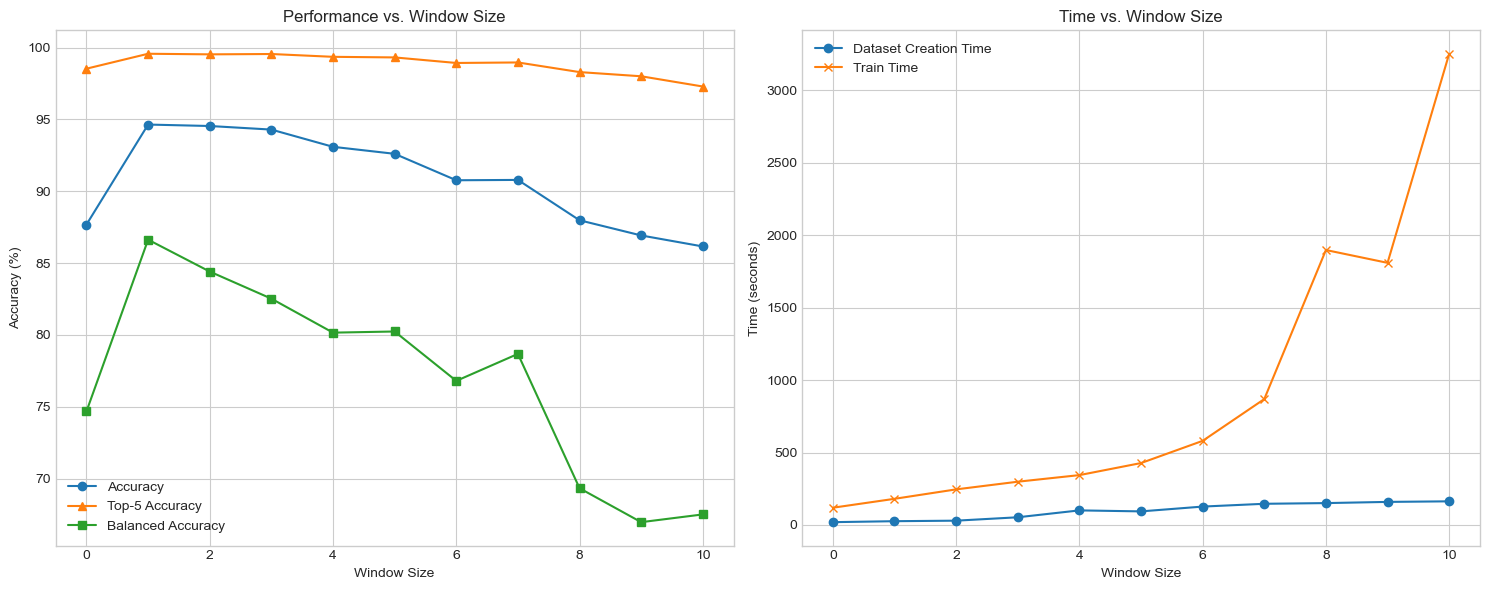

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("ablation_window_size_results.csv")

# Set style
plt.style.use("seaborn-v0_8-whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot accuracy curves
axs[0].plot(df["window_size"], df["accuracy"], label="Accuracy", marker='o')
axs[0].plot(df["window_size"], df["top5_accuracy"], label="Top-5 Accuracy", marker='^')
axs[0].plot(df["window_size"], df["balanced_accuracy"], label="Balanced Accuracy", marker='s')
axs[0].set_xlabel("Window Size")
axs[0].set_ylabel("Accuracy (%)")
axs[0].set_title("Performance vs. Window Size")
axs[0].legend()

# Plot time curves
axs[1].plot(df["window_size"], df["dataset_creation_time_sec"], label="Dataset Creation Time", marker='o')
axs[1].plot(df["window_size"], df["train_time_sec"], label="Train Time", marker='x')
axs[1].set_xlabel("Window Size")
axs[1].set_ylabel("Time (seconds)")
axs[1].set_title("Time vs. Window Size")
axs[1].legend()

plt.tight_layout()
plt.show()
fig.savefig("ablation_study_results.png", dpi=300)